# COde développé à partie de `pyroomacoustics` demo

In this IPython notebook, we demonstrate a few features of `pyroomacoustics`:

1. Its _pythonic_ and convenient object-oriented interface.
2. The Room Impulse Response (RIR) generator.
3. Provided reference algorithms. 

Below is a list of the examples (run all cells as some may depend on previous imports and results). 

1. [Creating a 2D/3D room](#room)
2. [Adding sources and microphones](#source_mic)
3. [Room Impulse Response generation and propagation simulation](#rir)
4. [Beamforming](#bf)
5. [Direction-of-arrival](#doa)
6. [Adaptive filtering](#af)
7. [STFT processing](#stft)
8. [Source Separation](#bss)

More information on the package can be found on the [Github repo](https://github.com/LCAV/pyroomacoustics) and from the [paper](https://arxiv.org/pdf/1710.04196.pdf), which can be cited as:

_R. Scheibler, E. Bezzam, I. Dokmanić, Pyroomacoustics: A Python package for audio room simulations and array processing algorithms, Proc. IEEE ICASSP, Calgary, CA, 2018._

Let's begin by importing the necessary libraries all of which can be installed with `pip`, even `pyroomacoustics`!

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
from scipy.optimize import curve_fit
import IPython
import pyroomacoustics as pra
import matplotlib 
#matplotlib.use("TkAgg")
#import ipympl

<a id='room'></a>
## Creating a 2D/3D room

We can build an arbitrary room by specifing its corners on a plane.

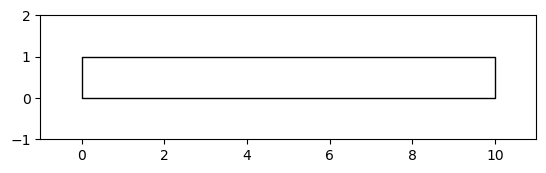

In [5]:
corners = np.array([[0,0], [0,1], [10,1], [10,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)
room_anechoic = pra.Room.from_corners(corners)

fig, ax = room.plot()
ax.set_xlim([-1, 11])
ax.set_ylim([-1, 2]);

If we wish to build a 3D room, we can "lift" the 2D shape by a specified height.

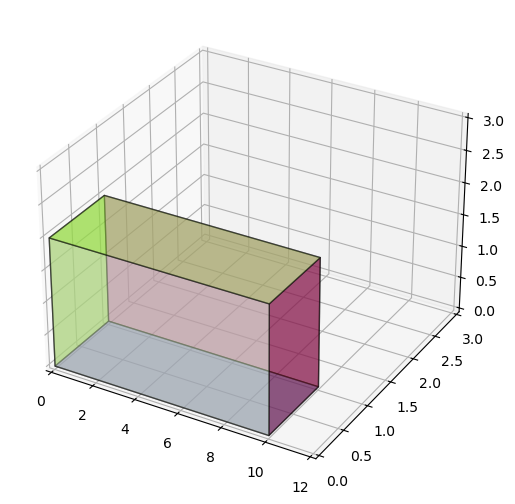

In [6]:
room = pra.Room.from_corners(corners)
room.extrude(2)
room_anechoic = pra.Room.from_corners(corners)
room_anechoic.extrude(2)

fig, ax = room.plot()
ax.set_xlim([0, 12])
ax.set_ylim([0, 3])
ax.set_zlim([0, 3]);

<a id='source_mic'></a>
## Adding sources and microphones

We can conveniently add sources to the room using the `add_source` method. We can also set a `numpy` array as the source's signal.

The speech file comes from the [CMU Arctic Database](http://www.festvox.org/cmu_arctic/).

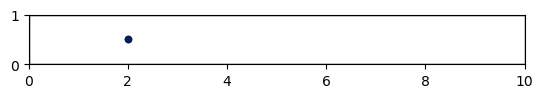

In [7]:
# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")

# add source to 2D room
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, air_absorption=True)
room.add_source([2.,0.5], signal=signal)

fig, ax = room.plot()

And similarly add a microphone array.

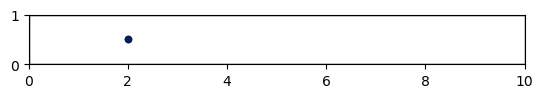

In [8]:
R = pra.circular_2D_array(center=[2.,2.], M=6, phi0=0, radius=0.1)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()

<a id='rir'></a>
## Definition of the signal and 3D room

Using the Image Source Model (ISM) we can compute the impulse response for each microphone. From the `Room` constructor it is possible to set the maximum ISM order and the absorption coefficient.

Fréquence définie : 

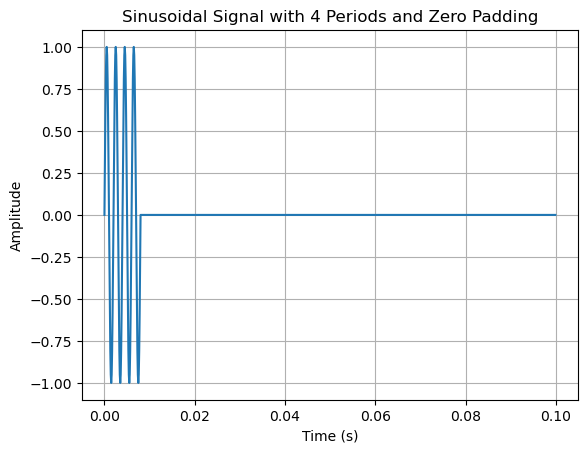

In [9]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# Plot the signal
plt.figure()
plt.plot(np.arange(len(extended_signal)) / samples, extended_signal)
plt.title("Sinusoidal Signal with 4 Periods and Zero Padding")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


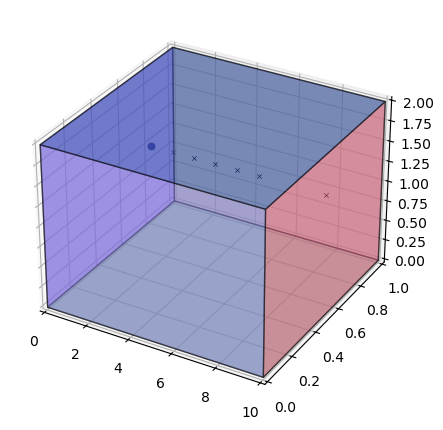

In [10]:
# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

# visualize 3D polyhedron room and image sources
# img_ordre donne le niveau maximum d'ordre de reflexion des sources
# Ce schéma affiche les sources et les sources mirrorés si les parois sont reflechissantes => + de sources mirroir
fig, ax = room.plot(img_order= ordre_voulu)
fig.set_size_inches(4,6)

Simulations for an anechoic room

## Pression en fonction de la fréquence

### f = 50Hz

La perte de pression linéique est de -18.109904434083674 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [0.26432489 0.13094263 0.08627765 0.06511097 0.052257   0.03285813]
list pression dB [82.42216134 76.32102137 72.69736631 70.25248366 68.34228926 64.3122569 ]


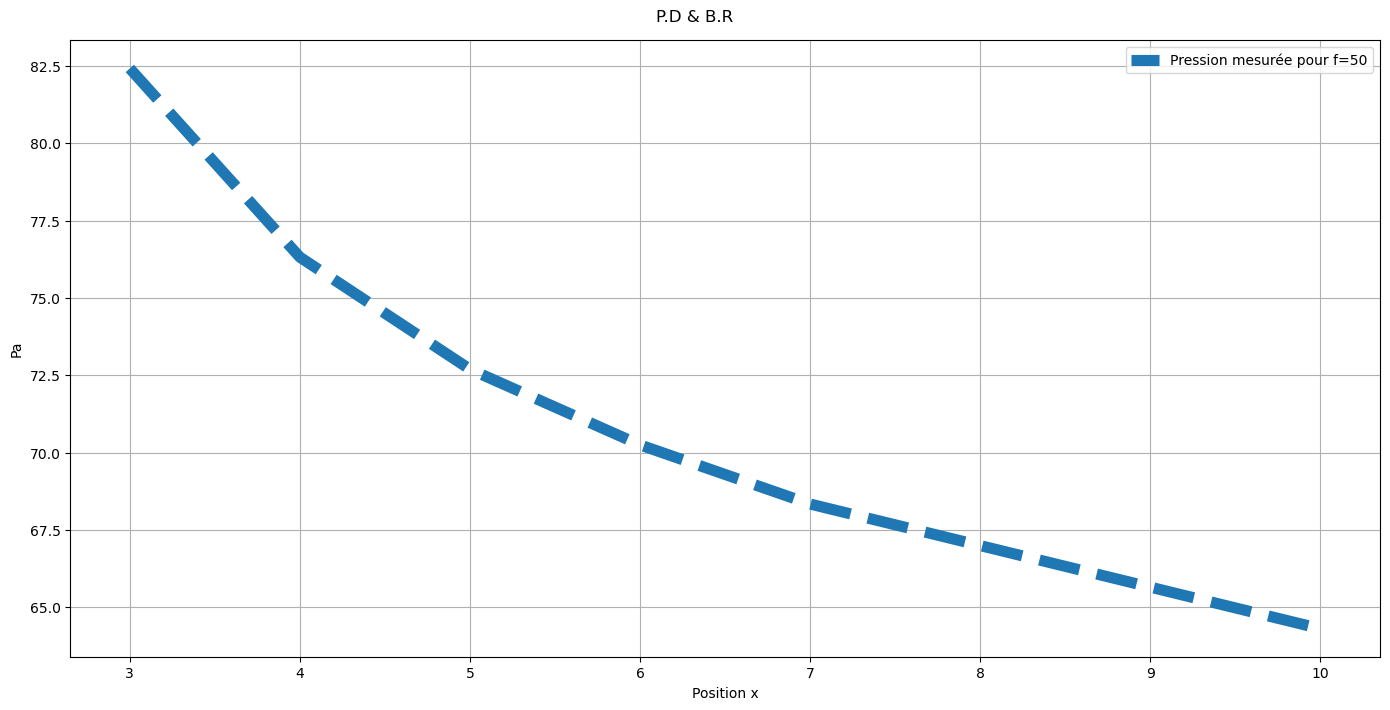

In [11]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 50 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 500Hz

La perte de pression linéique est de -18.089505482118966 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.05994624 0.52831596 0.35022681 0.26254184 0.2109316  0.13207133]
list pression dB [94.48507683 88.43727475 84.86638781 82.36337048 80.46223291 76.39557135]


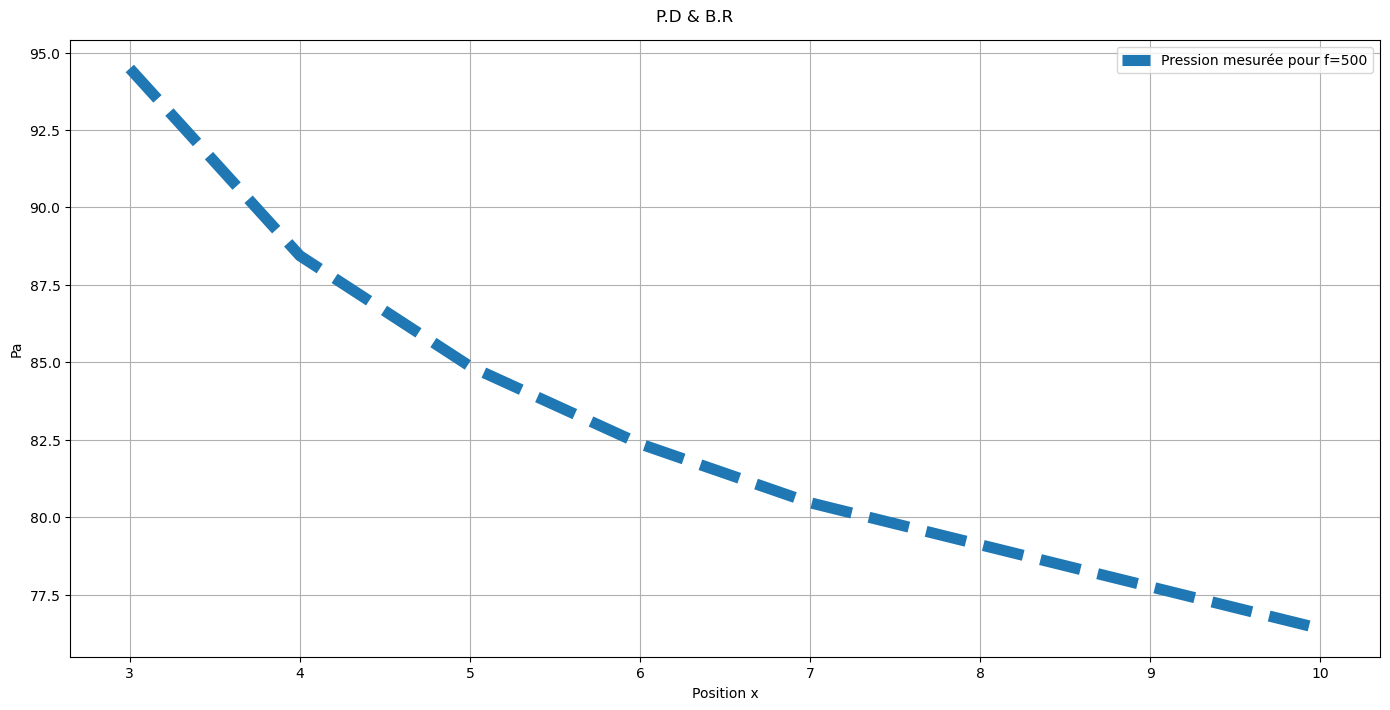

In [12]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 1kHz

La perte de pression linéique est de -18.019628798127897 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [0.98747728 0.50032889 0.33528303 0.25075096 0.19842495 0.12403541]
list pression dB [93.86994233 87.96451177 84.48763167 81.96425214 79.93132587 75.85031353]


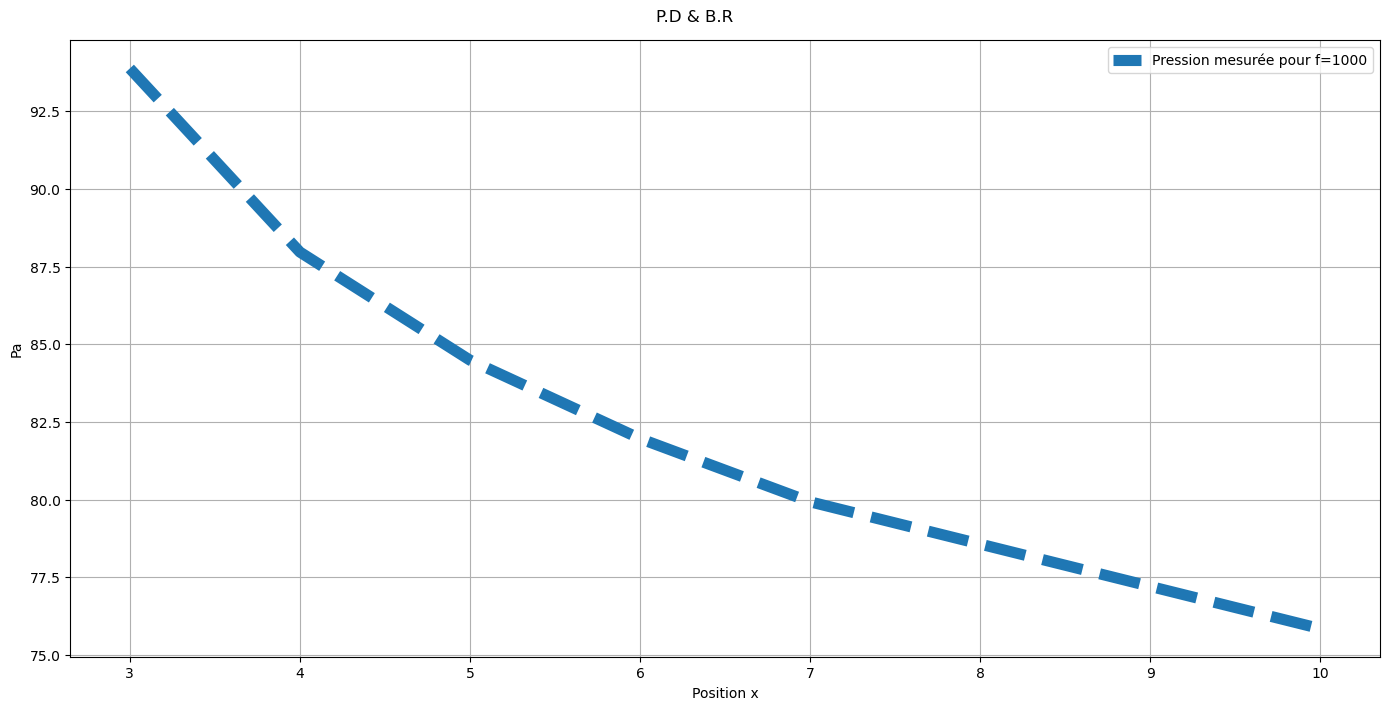

In [13]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 1000 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 10kHz

La perte de pression linéique est de -18.239232474109627 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [2.78967651e-15 1.34412613e-15 8.16753059e-16 5.29176449e-16
 4.63810395e-16 3.41658493e-16]
list pression dB [-197.10952301 -203.45179943 -207.77878452 -211.54858976 -212.69379035
 -215.34875548]


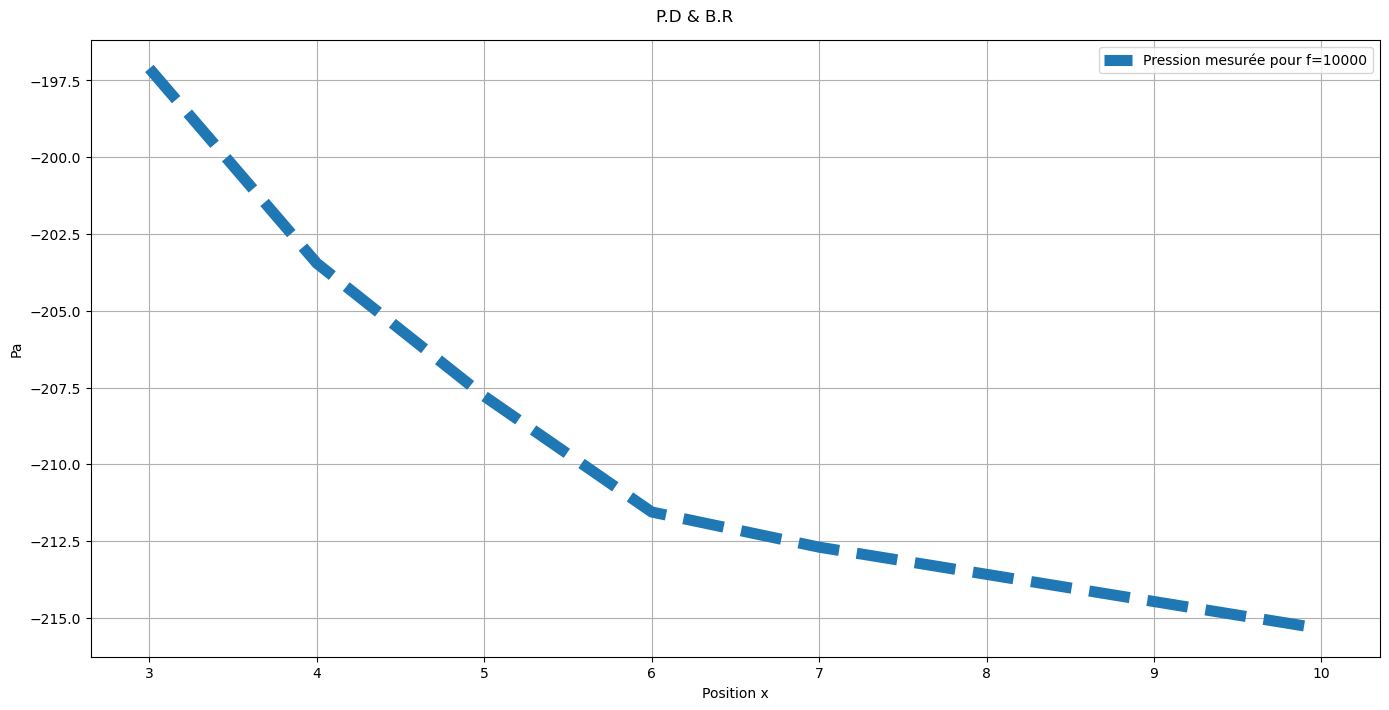

In [14]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 10000 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 100kHz

La perte de pression linéique est de -20.235123484880944 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [0.96117553 0.44945745 0.29709315 0.21195335 0.16486881 0.09355059]
list pression dB [93.63545421 87.03317176 83.43725273 80.5042057  78.32216989 73.40033072]


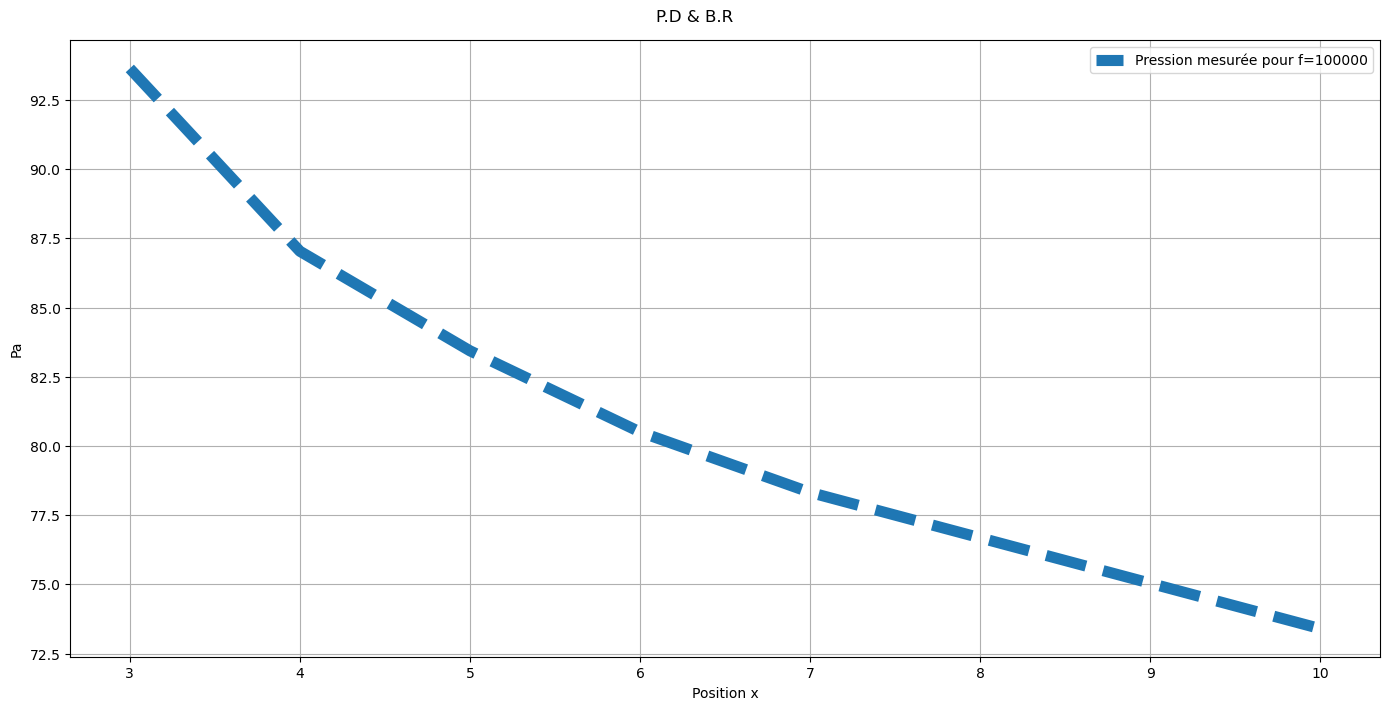

In [15]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 100000 # Frequency in Hz
samples = 1000000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 1MHz

La perte de pression linéique est de -21.08497186040529 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.98648593e-15 1.02188645e-15 6.45447397e-16 4.56689090e-16
 3.71629883e-16 1.75322195e-16]
list pression dB [-200.05889006 -205.83254711 -209.82338284 -212.82818718 -214.61838735
 -221.14386192]


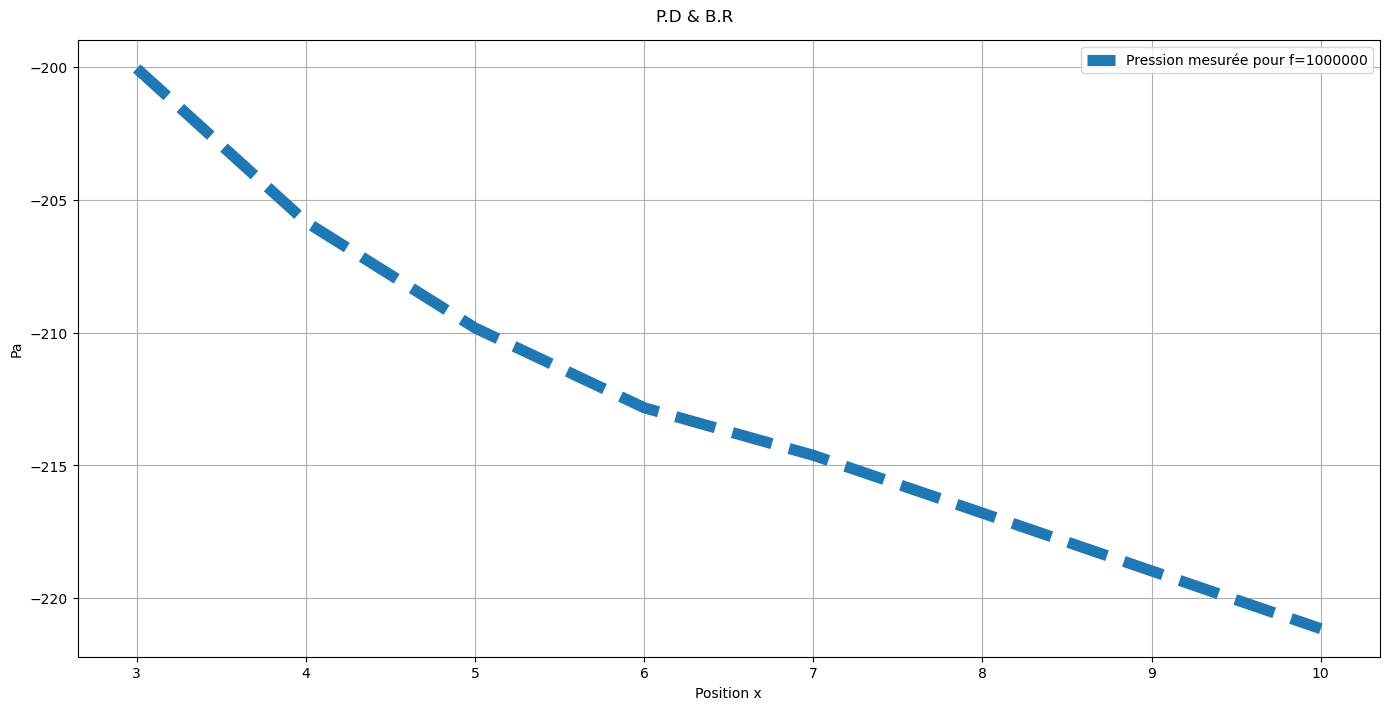

In [16]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 1000000 # Frequency in Hz
samples = 1000000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


## Pression en fonction de la reflexion

### Reflexion = 0

La perte de pression linéique est de -18.089505482118966 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.05994624 0.52831596 0.35022681 0.26254184 0.2109316  0.13207133]
list pression dB [94.48507683 88.43727475 84.86638781 82.36337048 80.46223291 76.39557135]


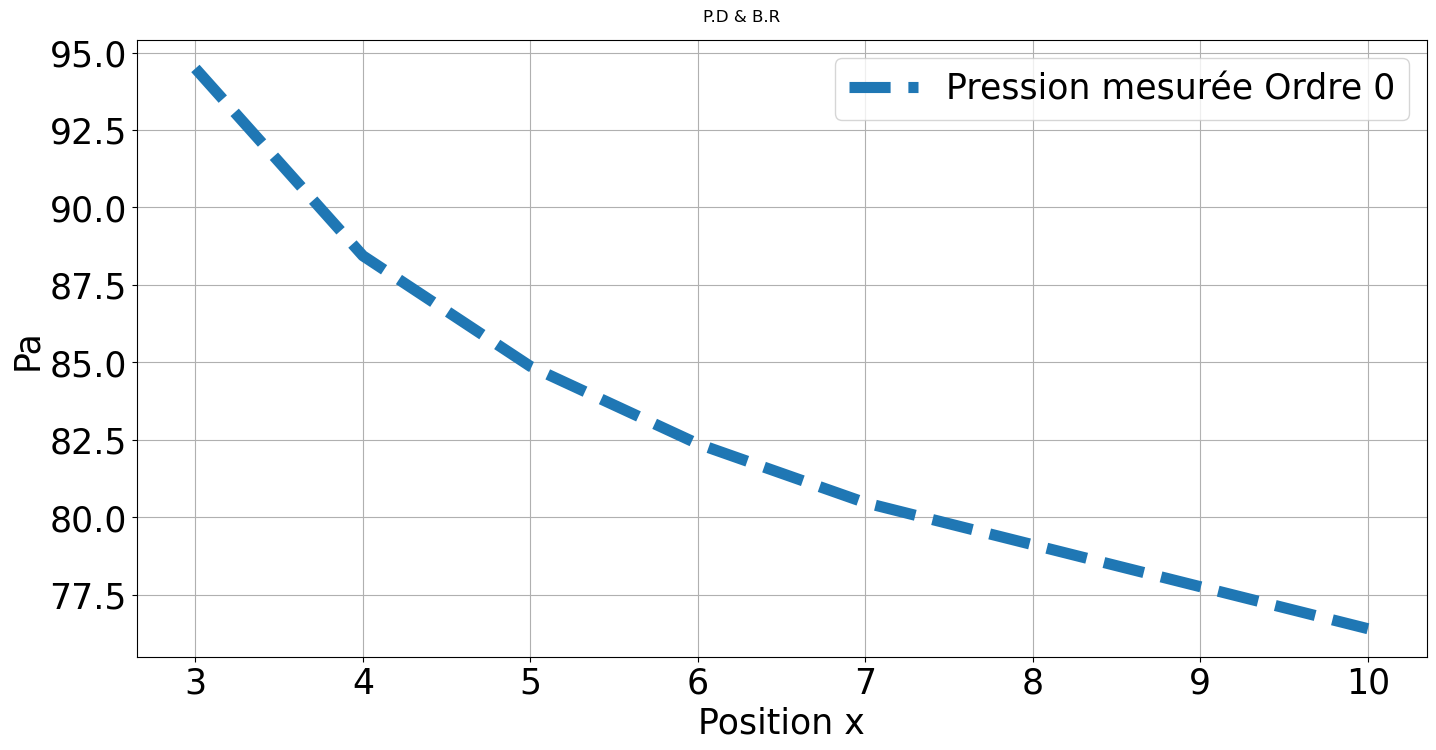

In [17]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée Ordre {ordre_voulu}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend(fontsize = 25)
plt.ylabel("Pa", fontsize = 25)
plt.tight_layout()
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid()
plt.xlabel("Position x", fontsize = 25)
plt.show()


### Reflexion = 2

La perte de pression linéique est de 5.4957941617965815 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.88646763 2.31395328 1.40268762 1.34397786 1.66996146 1.22903678]
list pression dB [ 99.49238723 101.26649182  96.91861934  96.5472424   98.43352908
  95.77069766]


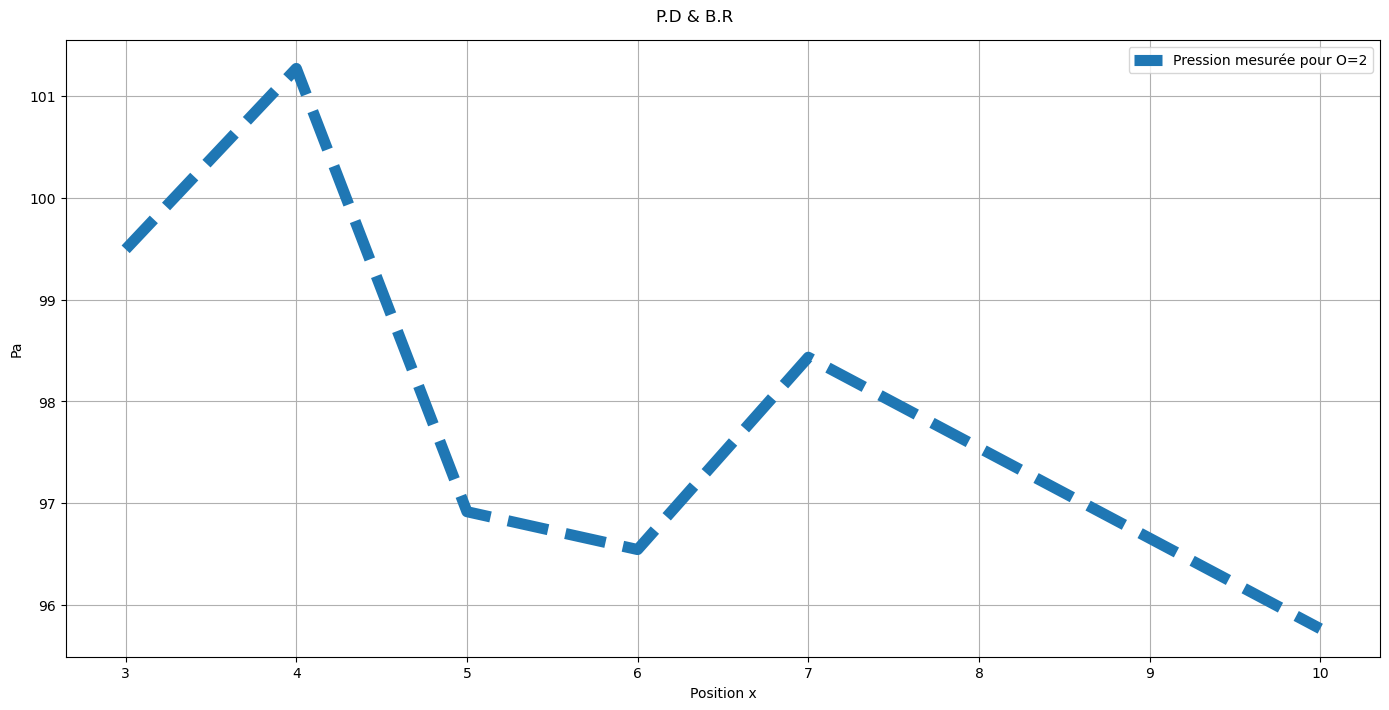

In [18]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 2

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (np.max(pressure_list_dB) -np.min(pressure_list_dB))
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour O={ordre_voulu}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### Reflexion = 3

La perte de pression linéique est de 7.875728045049698 dB 

La perte de pression linéique est de -7.875728045049698 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.45230073 1.34176987 1.01787332 0.85129981 0.83525597 0.58650289]
list pression dB [97.22053121 96.53296082 94.13327473 92.58105082 92.4157919  89.34480316]


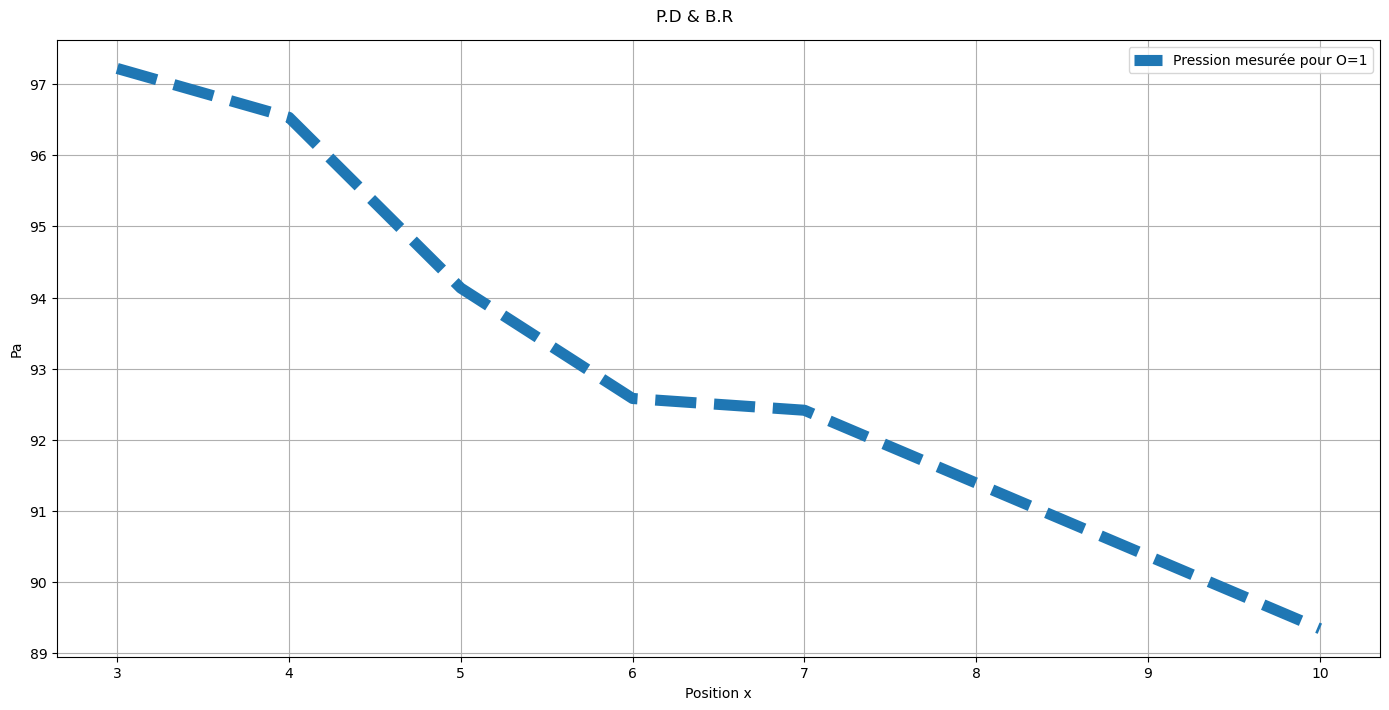

In [19]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 1

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (np.max(pressure_list_dB) -np.min(pressure_list_dB))
print(f"La perte de pression linéique est de {diff} dB \n")

diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour O={ordre_voulu}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### Reflexion = 5

La perte de pression linéique est de -6.2232245998245475 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [4.25563863 3.17584339 3.26716478 3.56162409 3.1688167  2.07875598]
list pression dB [106.55869493 104.01658163 104.26282087 105.01236168 103.99734246
 100.33547033]


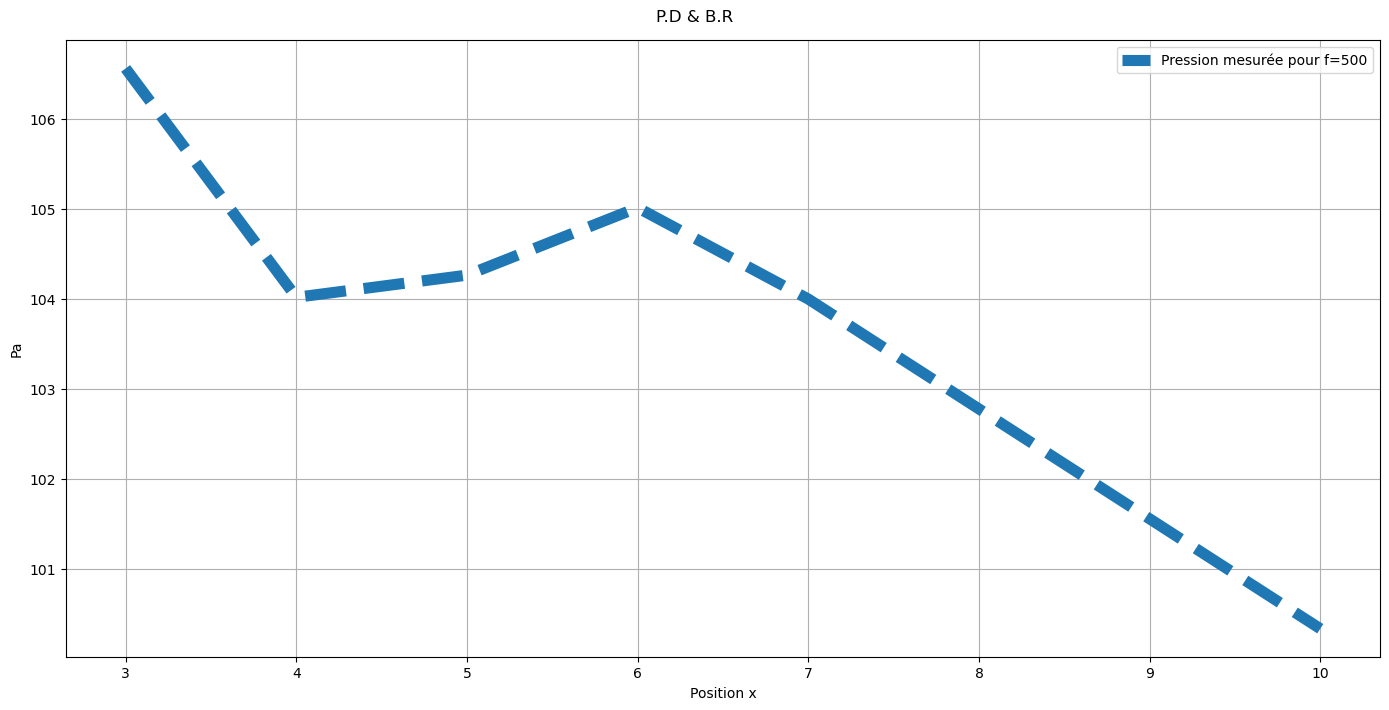

In [20]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 5

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### Reflexion = 10

La perte de pression linéique est de 5.9643506891026306 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [0.8527985  0.66094068 0.77909166 0.59179396 0.42916954 0.57464843]
list pression dB [92.59632861 90.38264968 91.81117125 89.42281059 86.63197792 89.16744464]


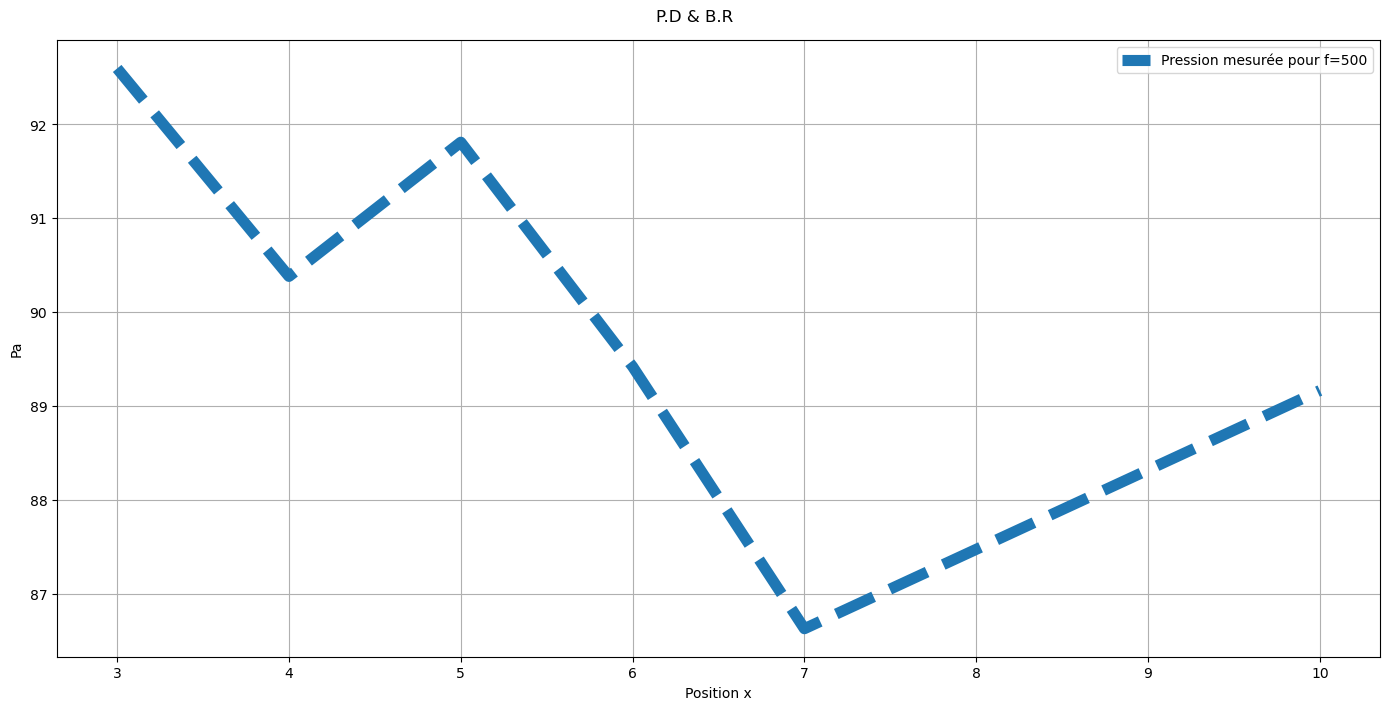

In [21]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 1000000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 10

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (np.max(pressure_list_dB) -np.min(pressure_list_dB))
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


## RIR et suite

### RIR

Moreover, we can plot the RIR for each microphone once the image sources have been computed.

##### Scheme definition with high reflexability

In [22]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 48000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 5

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))

# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()

#### Creation bande d'octaves

In [23]:
octav_test = pra.acoustics.octave_bands(fc= 5000, third= False, start= 0, n=8)
octav_test

(array([[  3535.53390593,   7071.06781187],
        [  7071.06781187,  14142.13562373],
        [ 14142.13562373,  28284.27124746],
        [ 28284.27124746,  56568.54249492],
        [ 56568.54249492, 113137.08498985],
        [113137.08498985, 226274.1699797 ],
        [226274.1699797 , 452548.33995939],
        [452548.33995939, 905096.67991878]]),
 array([  5000.,  10000.,  20000.,  40000.,  80000., 160000., 320000.,
        640000.]))

#### Octave bande Factory

In [24]:
octave_factory_test = pra.acoustics.OctaveBandsFactory(base_frequency = 100, fs = 10000, n_fft = 512, keep_dc= False)
print(octave_factory_test.get_bw())
#plt.plot(octave_factory_test.get_bw())

[  70.71067812  141.42135624  282.84271247  565.68542495 1131.3708499
 2262.7416998 ]


#### Analysis

In [25]:
octave_factory_test.analysis(extended_signal)
print(octave_factory_test.all_materialsà)

AttributeError: 'OctaveBandsFactory' object has no attribute 'all_materialsà'

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import pyroomacoustics as pra

# Fonction pour créer un filtre passe-bande pour une bande d’octave
def octave_band_filter(rir, fs, fc):
    f_min = fc / np.sqrt(2)
    f_max = fc * np.sqrt(2)
    sos = butter(N=4, Wn=[0.01, 0.99], btype='band', output='sos')
    return sosfilt(sos, rir)

# Simulation d’une pièce avec pyroomacoustics
corners = np.array([[0, 0], [10, 0], [10, 5], [0, 5]]).T
room = pra.Room.from_corners(corners, fs=16000, max_order=5, materials=pra.Material(0.2), air_absorption=True)
room.extrude(3.0)

# Ajout de la source et des microphones
room.add_source([2, 2, 1.5])
R = np.array([[3, 5, 7], [2, 2, 2], [1.5, 1.5, 1.5]])
room.add_microphone(R)

# Calcul des RIR
room.compute_rir()
rir = room.rir[0][0]  # RIR pour le premier micro et la source

# Fréquences centrales des bandes d’octaves
octave_bands = [125, 250, 500, 1000, 2000, 4000, 8000]
fs = room.fs  # Fréquence d’échantillonnage
rir_filtered_bands = []

# Filtrage de la RIR dans chaque bande d’octave
for fc in octave_bands:
    rir_filtered = octave_band_filter(rir, fs, fc)
    rir_filtered_bands.append(rir_filtered)

# Tracé des RIR par bande d’octave
plt.figure(figsize=(10, 6))
for i, fc in enumerate(octave_bands):
    plt.bar(rir_filtered_bands[i], label=f'{fc} Hz')
plt.legend()
plt.xlabel('Échantillons')
plt.ylabel('Amplitude')
plt.title('RIR filtrées en bandes d’octave')
plt.show()


TypeError: bar() missing 1 required positional argument: 'height'

<Figure size 1000x600 with 0 Axes>

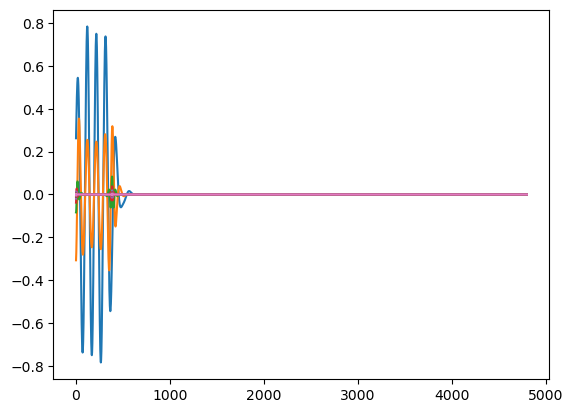

In [40]:
c = pra.acoustics.OctaveBandsFactory(125)
c.analysis(extended_signal)
plt.plot(c.analysis(extended_signal))

##### Ordre = 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\pierr\AppData\Local\Temp\ipykernel_17956\847357357.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


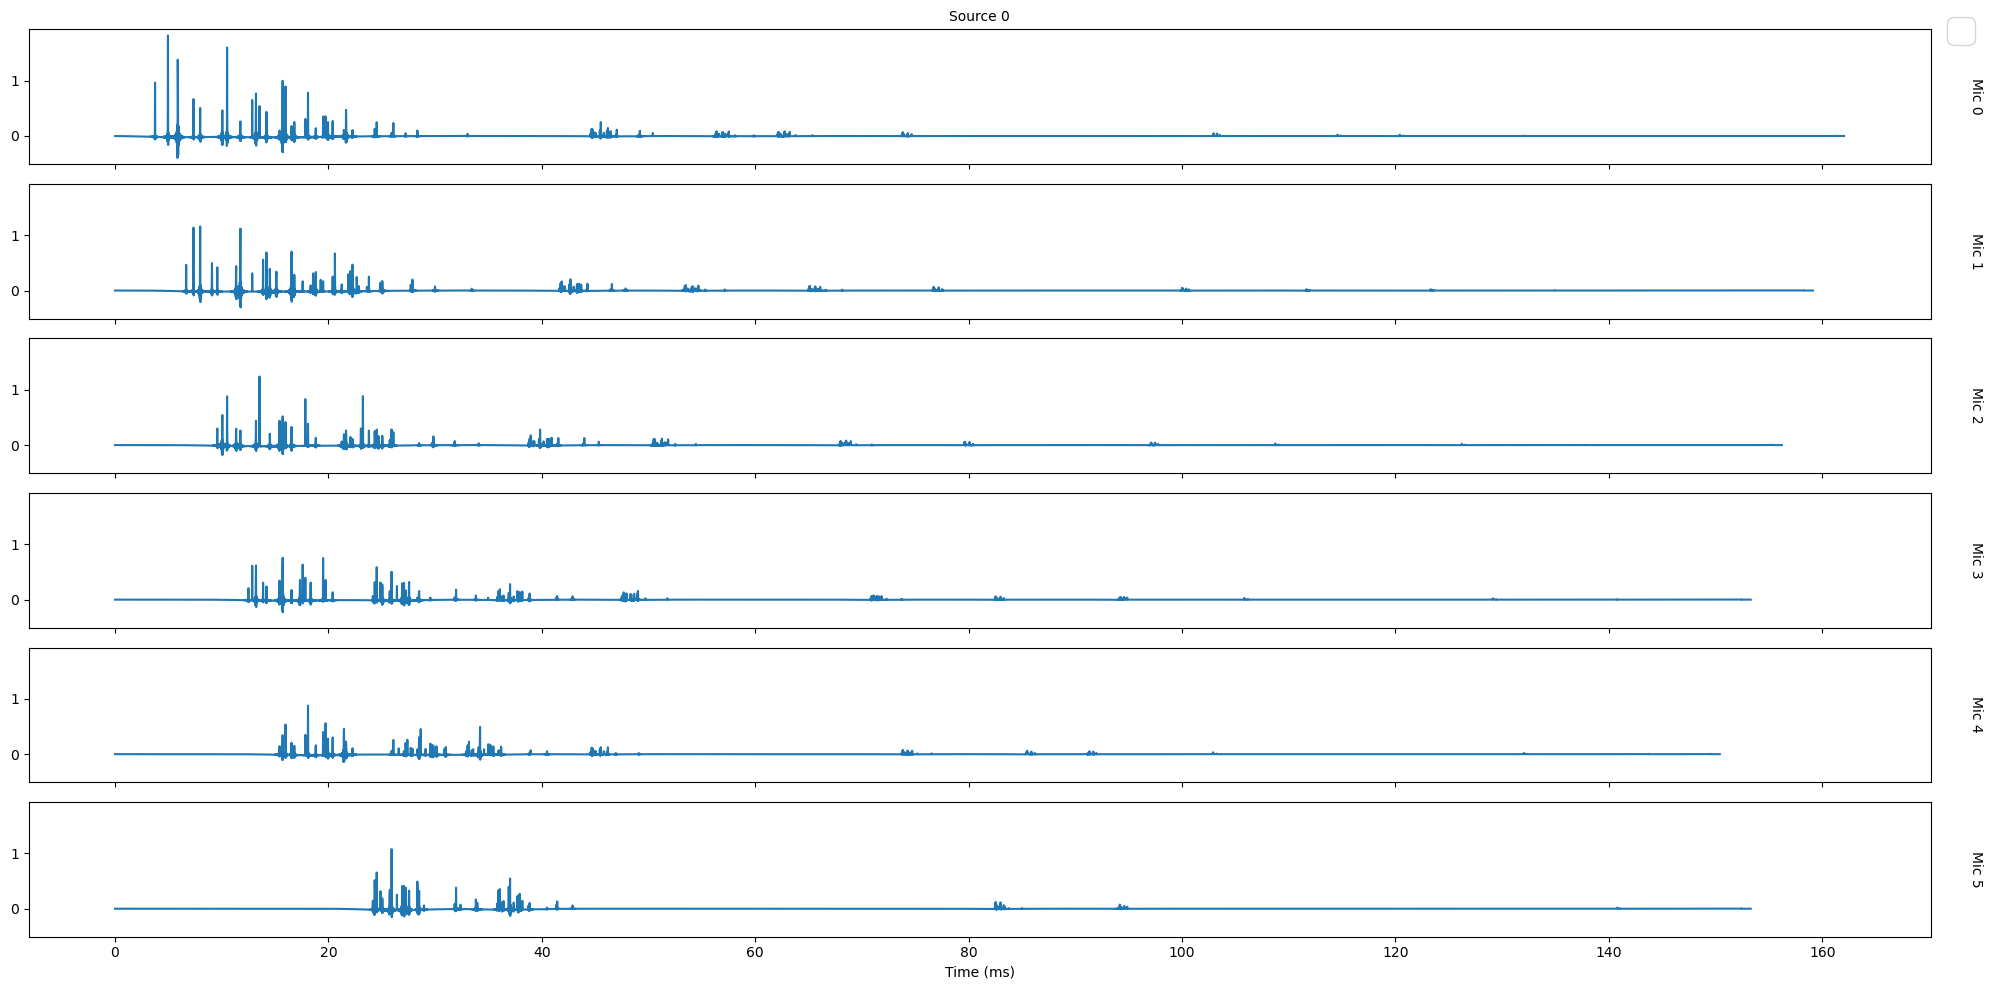

In [35]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.legend(fontsize = 25)
fig.tight_layout()
fig.show()


##### Ordre = 10

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\pierr\AppData\Local\Temp\ipykernel_17956\847357357.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


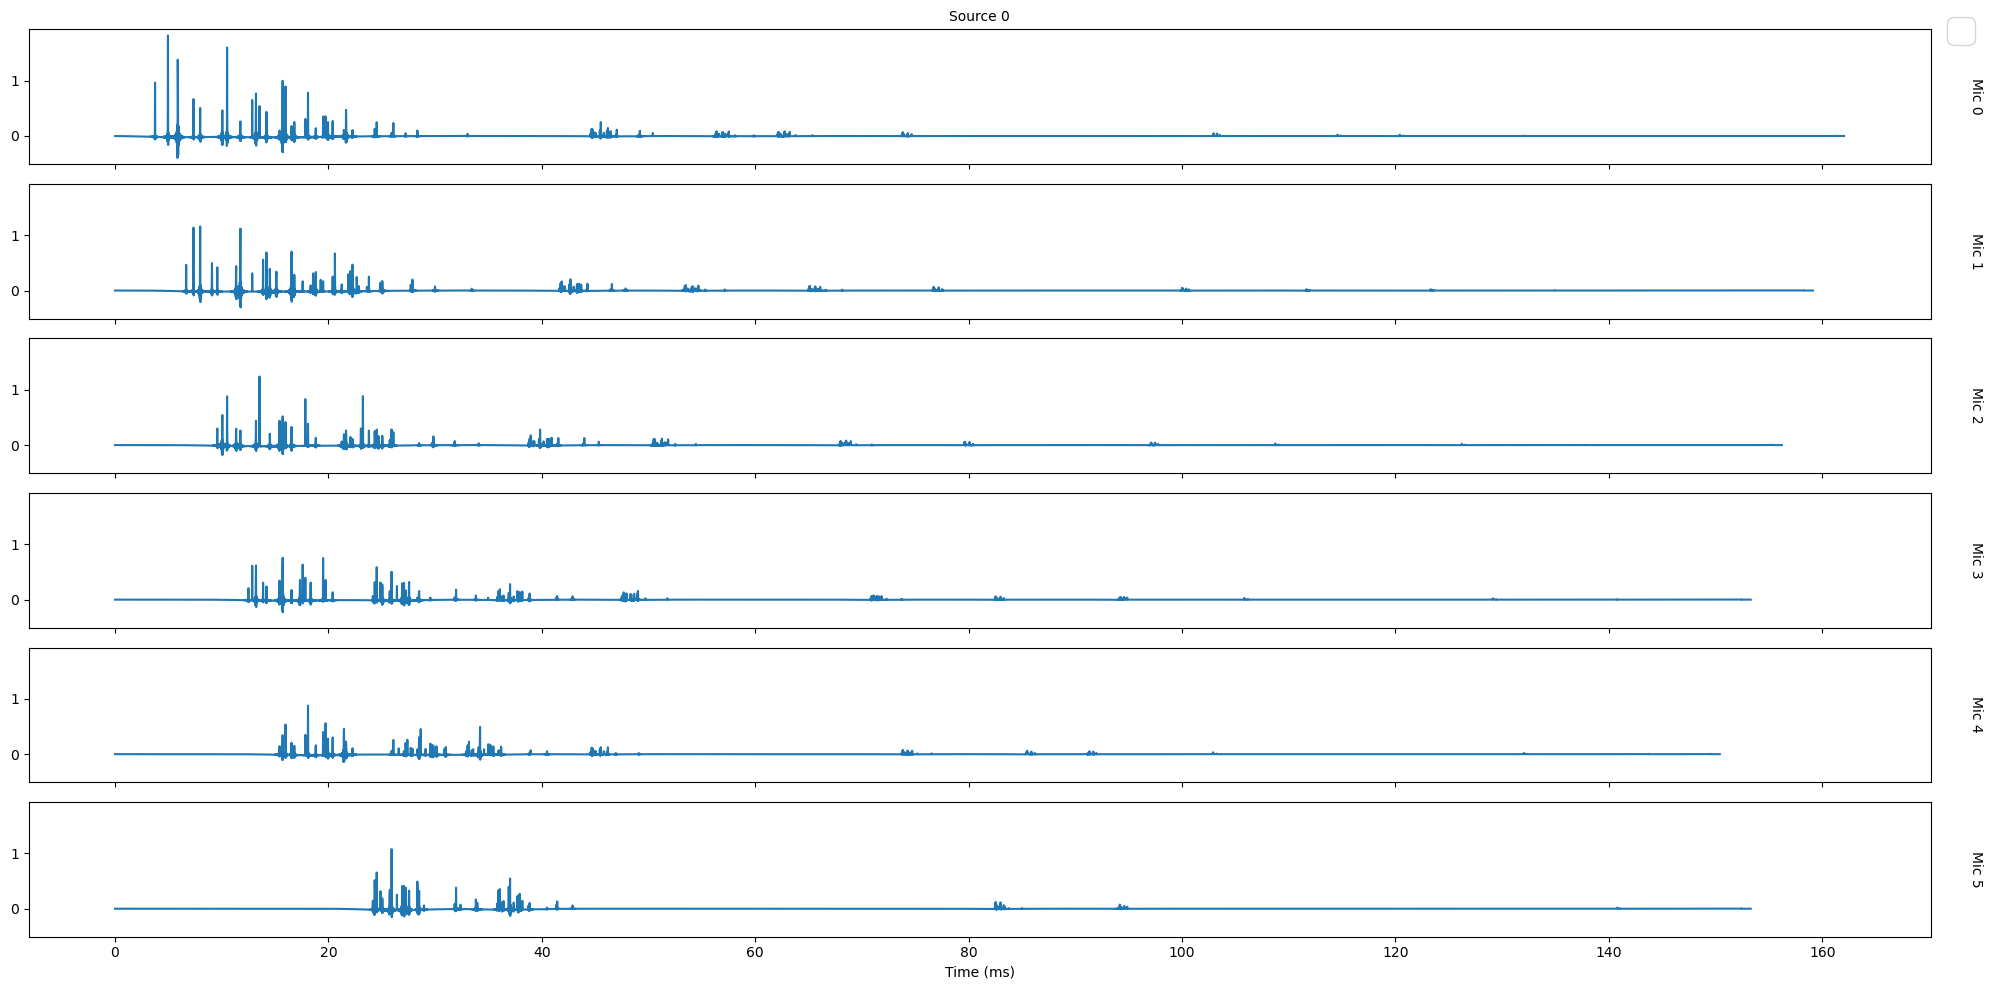

In [33]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.legend(fontsize = 25)
fig.tight_layout()
fig.show()


##### Signal convolué

In [21]:
np.convolve(signal,room.rir[0][0])

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

We can now measure the reverberation time of the RIR.

The RT60 is 148 ms


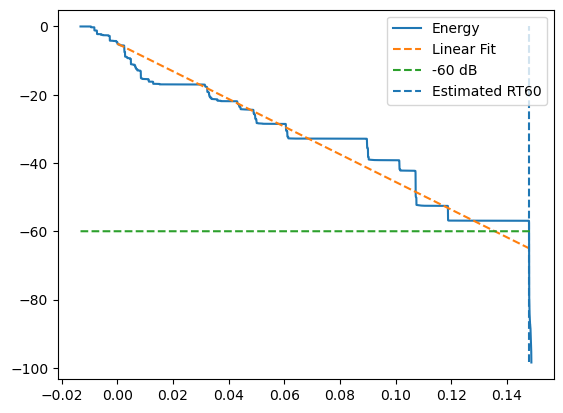

In [37]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

Moreover, we can simulate our signal convolved with these impulse responses as such:

(6, 1316)


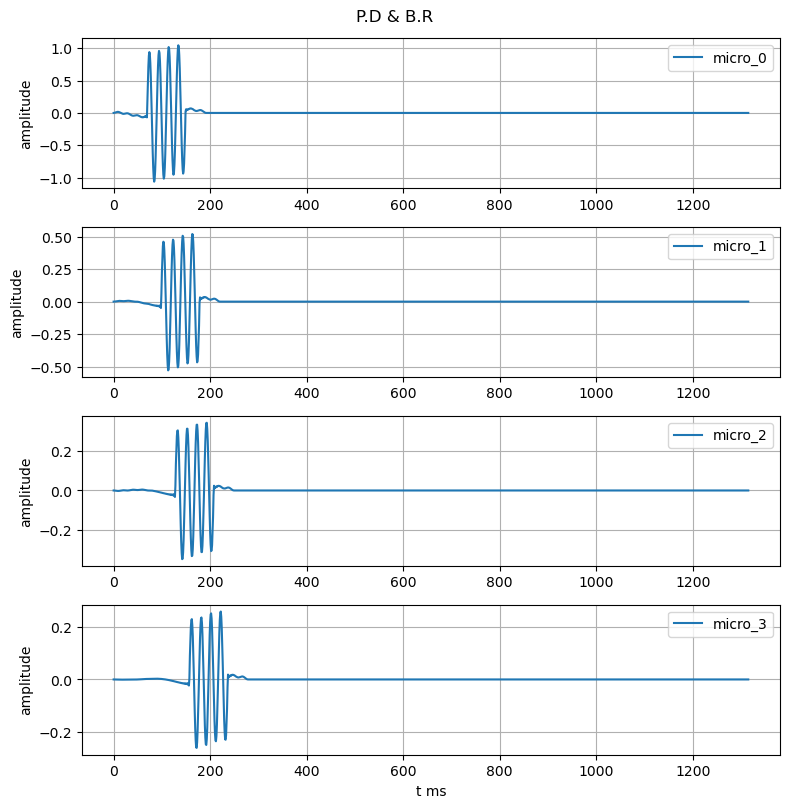

In [ ]:
room.simulate()
print(room.mic_array.signals.shape)
plt.figure(figsize=[8, 8])
plt.suptitle("P.D & B.R")
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(room.mic_array.signals[i],label = f'micro_{i}')
    plt.legend()
    plt.ylabel("amplitude")
    plt.tight_layout()
    plt.grid()

plt.xlabel("t ms")
plt.show()


# Atmosphère martienne

<a id='room'></a>
## Creating a 2D/3D room

We can build an arbitrary room by specifing its corners on a plane.

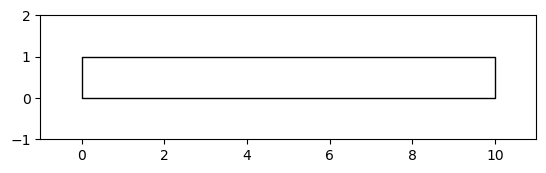

In [26]:
corners = np.array([[0,0], [0,1], [10,1], [10,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)
room_anechoic = pra.Room.from_corners(corners)

fig, ax = room.plot()
ax.set_xlim([-1, 11])
ax.set_ylim([-1, 2]);

If we wish to build a 3D room, we can "lift" the 2D shape by a specified height.

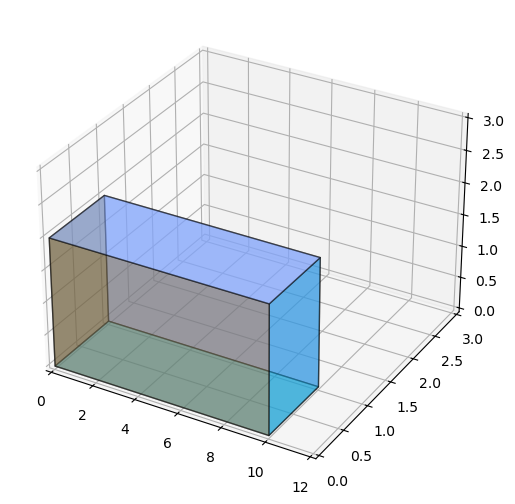

In [27]:
room = pra.Room.from_corners(corners)
room.extrude(2)
room_anechoic = pra.Room.from_corners(corners)
room_anechoic.extrude(2)

fig, ax = room.plot()
ax.set_xlim([0, 12])
ax.set_ylim([0, 3])
ax.set_zlim([0, 3]);

<a id='rir'></a>
## Definition of the signal and 3D room

Using the Image Source Model (ISM) we can compute the impulse response for each microphone. From the `Room` constructor it is possible to set the maximum ISM order and the absorption coefficient.

Fréquence définie : 

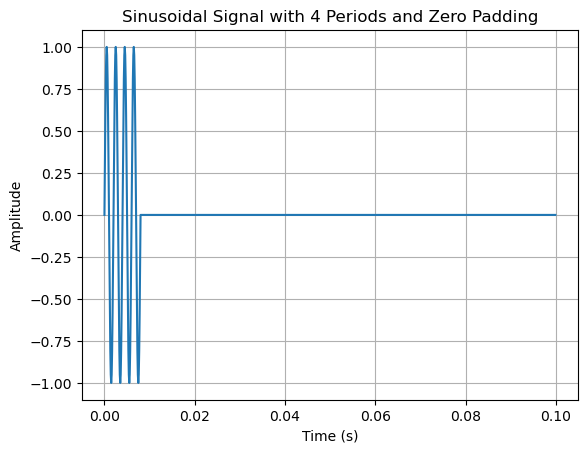

In [28]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# Plot the signal
plt.figure()
plt.plot(np.arange(len(extended_signal)) / samples, extended_signal)
plt.title("Sinusoidal Signal with 4 Periods and Zero Padding")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


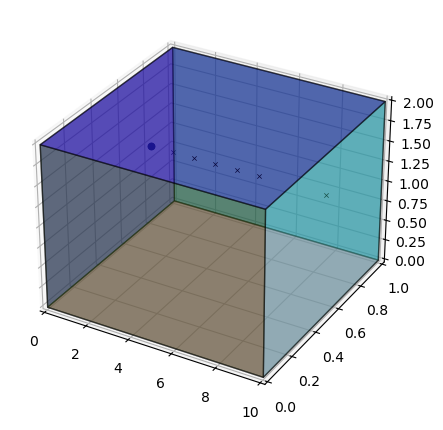

In [30]:
# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# Propriétés de l'atmosphère martienne
sound_speed_mars = 270  # Vitesse du son sur Mars en m/s
absorption_mars = 0.05  # Approximation pour l'absorption 

# Setting the room
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.c = sound_speed_mars  # Ajuste la vitesse du son
room.extrude(2., materials=pra.Material(0.2, 0.15))

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

# visualize 3D polyhedron room and image sources
fig, ax = room.plot(img_order= ordre_voulu)
fig.set_size_inches(4,6)

## Test RIR

##### Signal convolué

In [47]:
np.convolve(signal,room.rir[0][0])

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

We can now measure the reverberation time of the RIR.

The RT60 is 6 ms


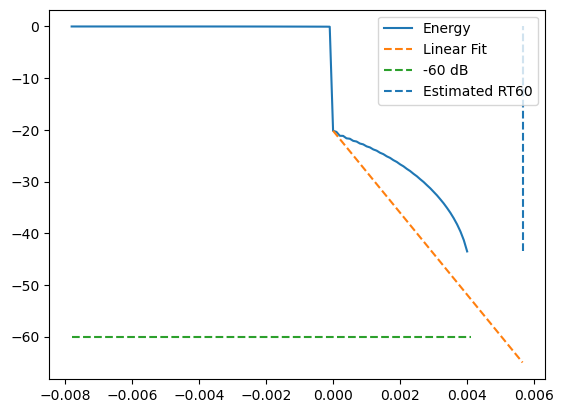

In [48]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

Moreover, we can simulate our signal convolved with these impulse responses as such:

(6, 1378)


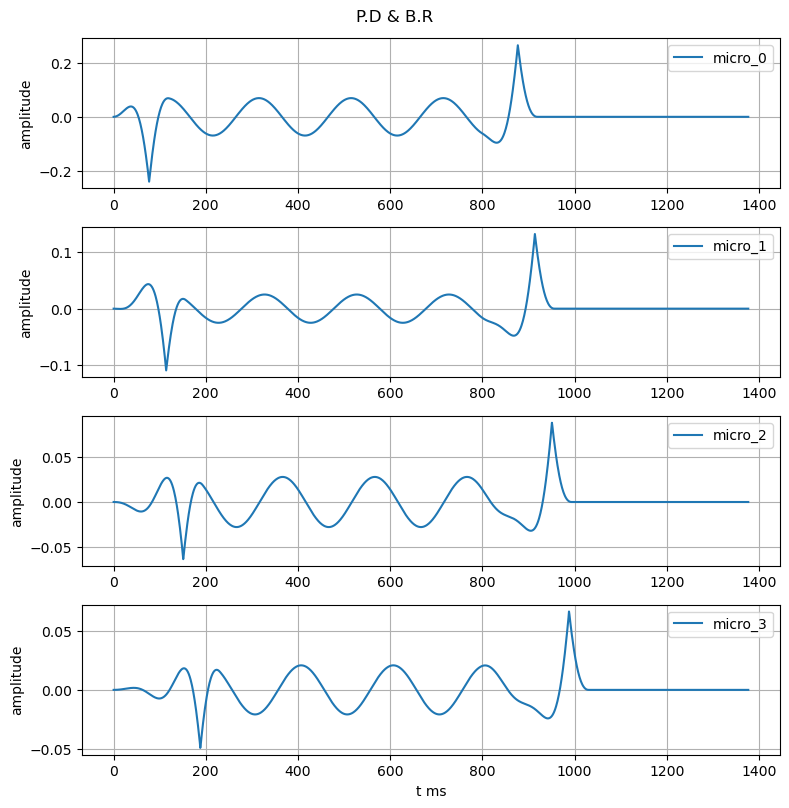

In [49]:
room.simulate()
print(room.mic_array.signals.shape)
plt.figure(figsize=[8, 8])
plt.suptitle("P.D & B.R")
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(room.mic_array.signals[i],label = f'micro_{i}')
    plt.legend()
    plt.ylabel("amplitude")
    plt.tight_layout()
    plt.grid()

plt.xlabel("t ms")
plt.show()


## Pression en fonction de la fréquence

### f = 50Hz

La perte de pression linéique est de -18.180680828326985 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [0.26547349 0.13256277 0.08824178 0.06606743 0.05274812 0.0327331 ]
list pression dB [82.45982343 76.42783175 72.89288544 70.37914786 68.42353928 64.2791426 ]


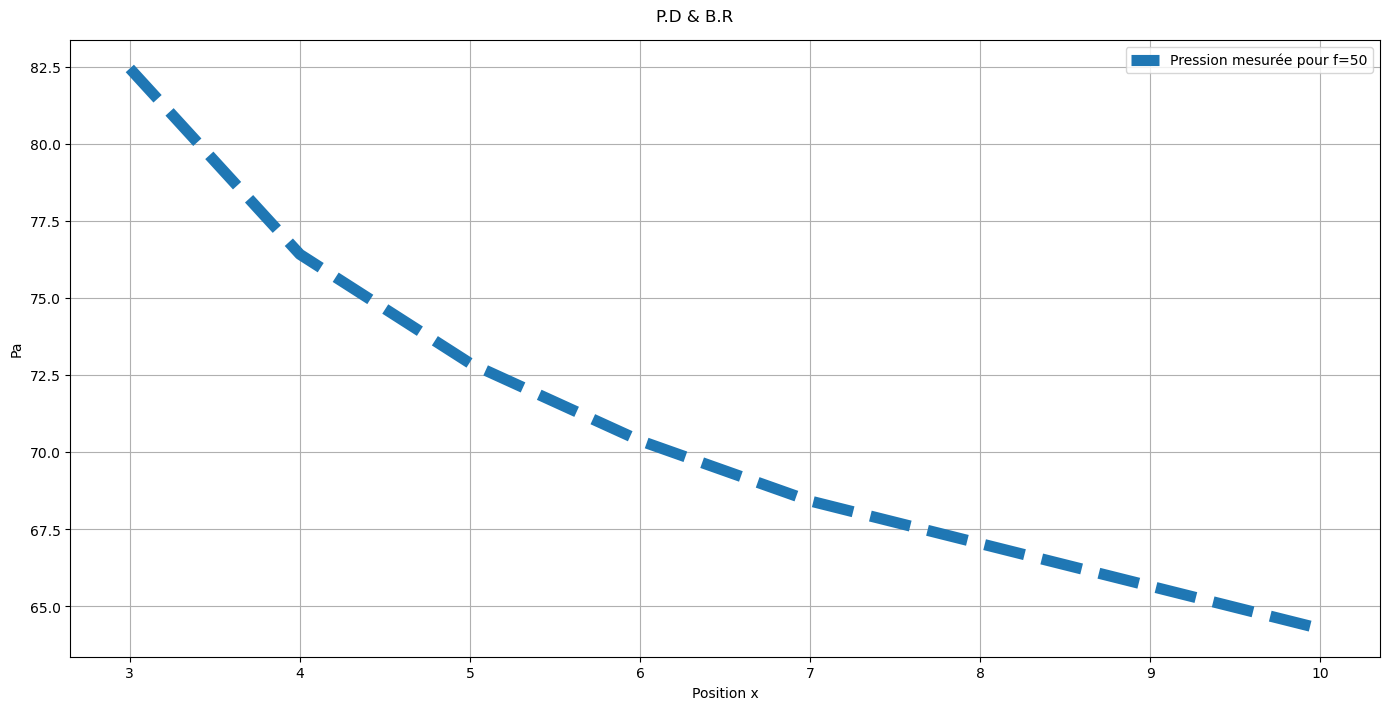

In [46]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 50 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0


# Propriétés de l'atmosphère martienne
sound_speed_mars = 270  # Vitesse du son sur Mars en m/s
absorption_mars = 0.05  # Approximation pour l'absorption 

# Setting the room
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.c = sound_speed_mars  # Ajuste la vitesse du son
room.extrude(2., materials=pra.Material(0.2, 0.15))

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 500Hz

La perte de pression linéique est de -18.089505482118966 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.05994624 0.52831596 0.35022681 0.26254184 0.2109316  0.13207133]
list pression dB [94.48507683 88.43727475 84.86638781 82.36337048 80.46223291 76.39557135]


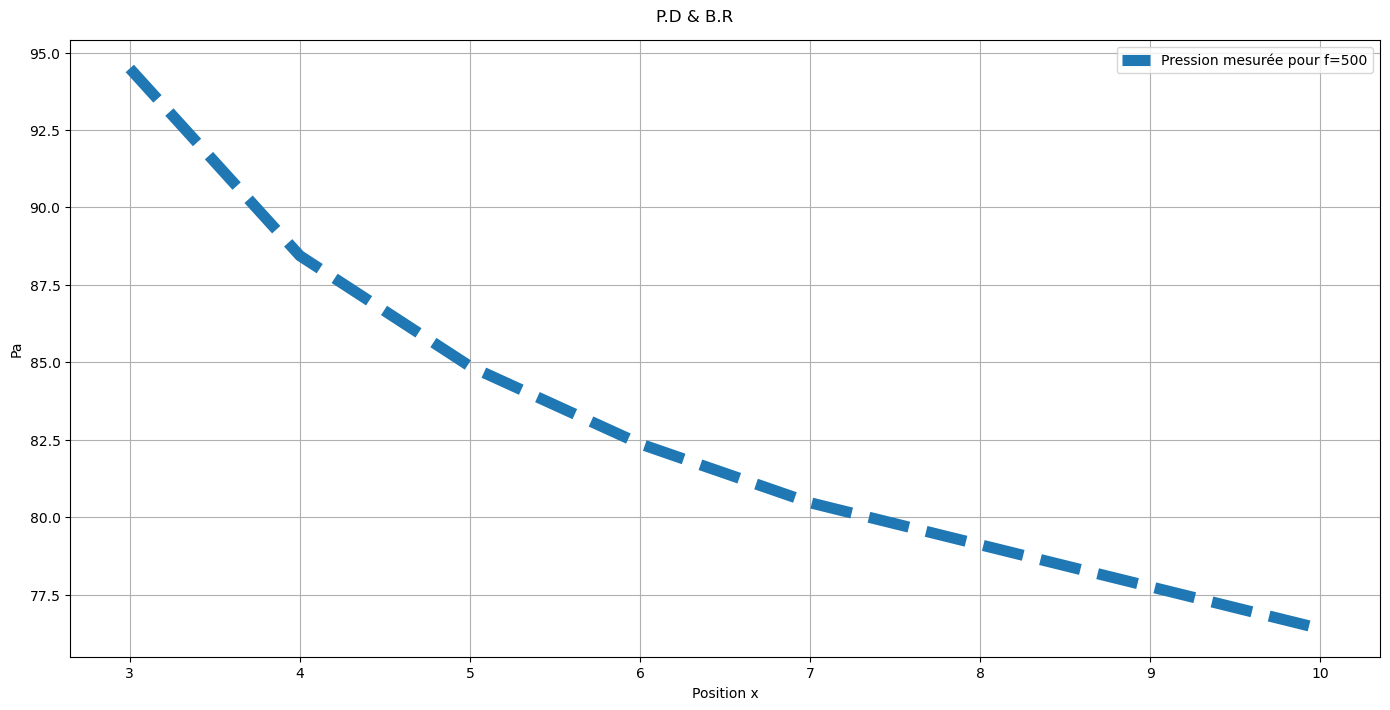

In [32]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 1kHz

La perte de pression linéique est de -18.019628798127897 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [0.98747728 0.50032889 0.33528303 0.25075096 0.19842495 0.12403541]
list pression dB [93.86994233 87.96451177 84.48763167 81.96425214 79.93132587 75.85031353]


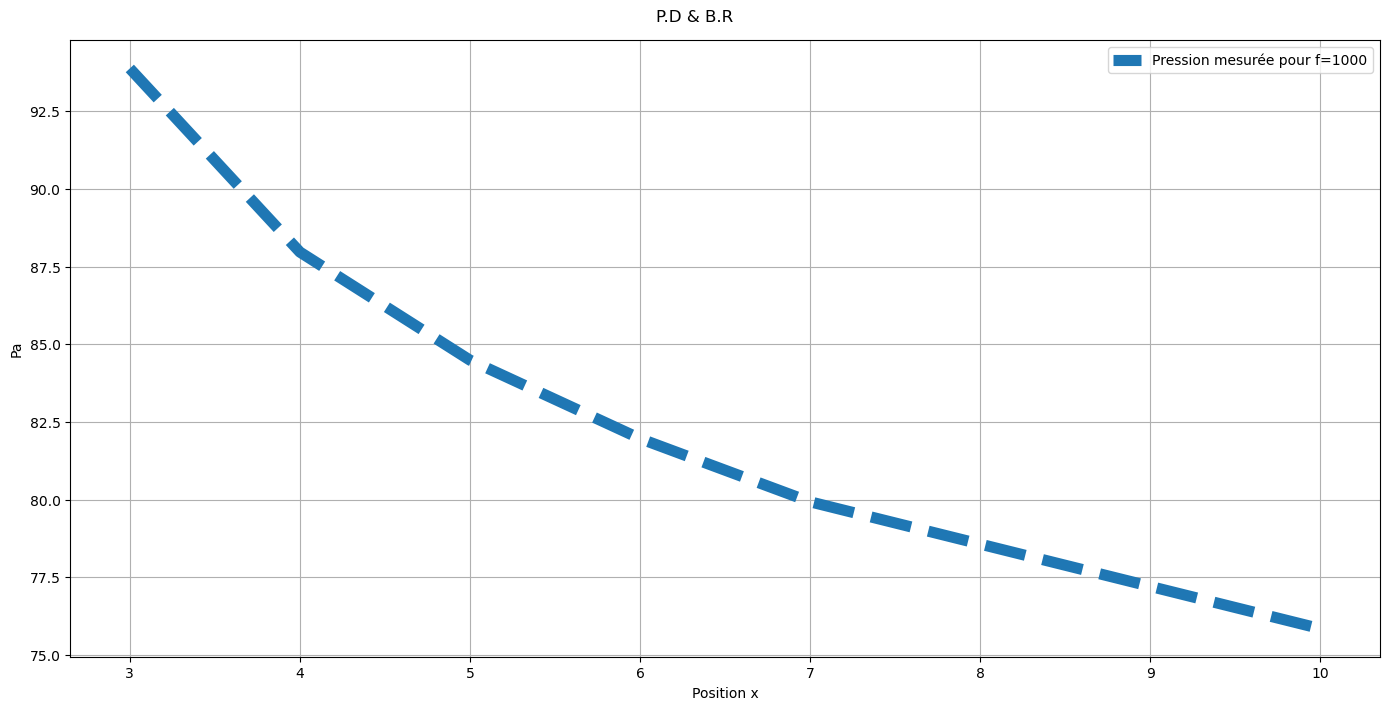

In [33]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 1000 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 10kHz

La perte de pression linéique est de -18.239232474109627 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [2.78967651e-15 1.34412613e-15 8.16753059e-16 5.29176449e-16
 4.63810395e-16 3.41658493e-16]
list pression dB [-197.10952301 -203.45179943 -207.77878452 -211.54858976 -212.69379035
 -215.34875548]


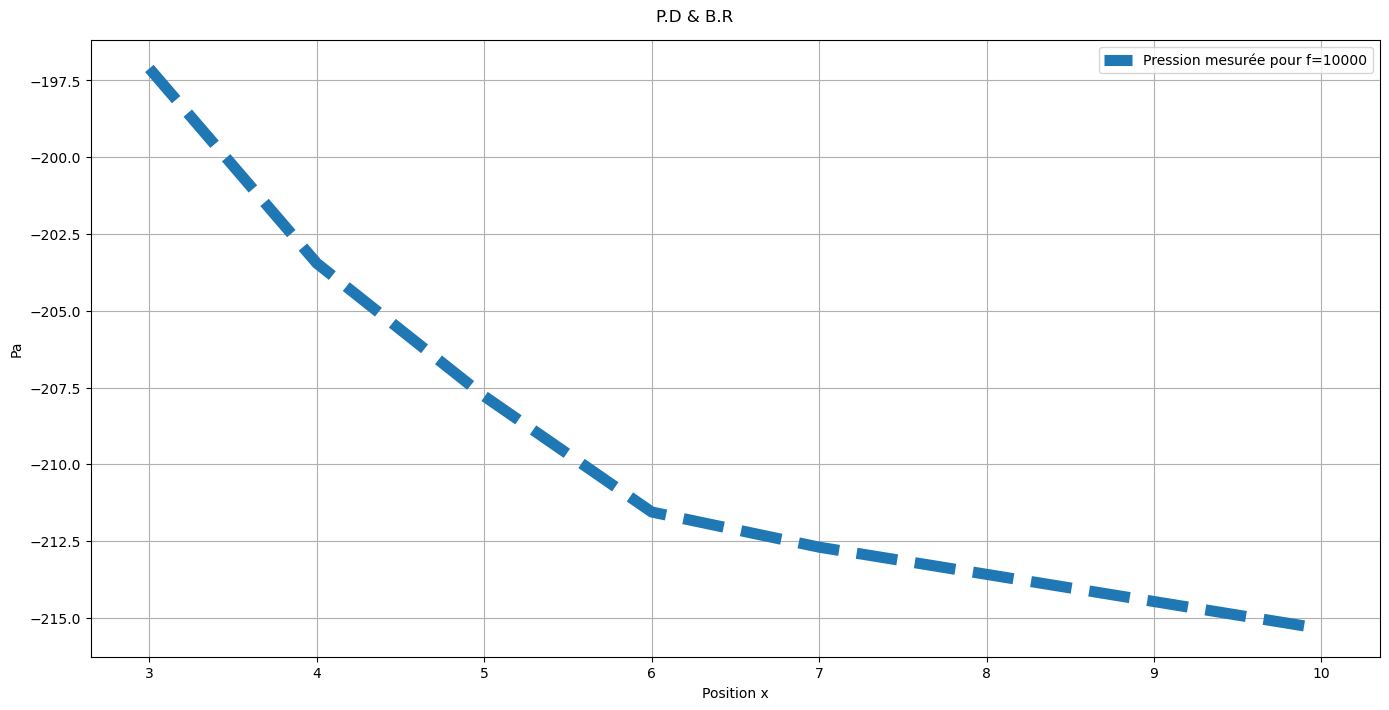

In [34]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 10000 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 100kHz

La perte de pression linéique est de -20.235123484880944 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [0.96117553 0.44945745 0.29709315 0.21195335 0.16486881 0.09355059]
list pression dB [93.63545421 87.03317176 83.43725273 80.5042057  78.32216989 73.40033072]


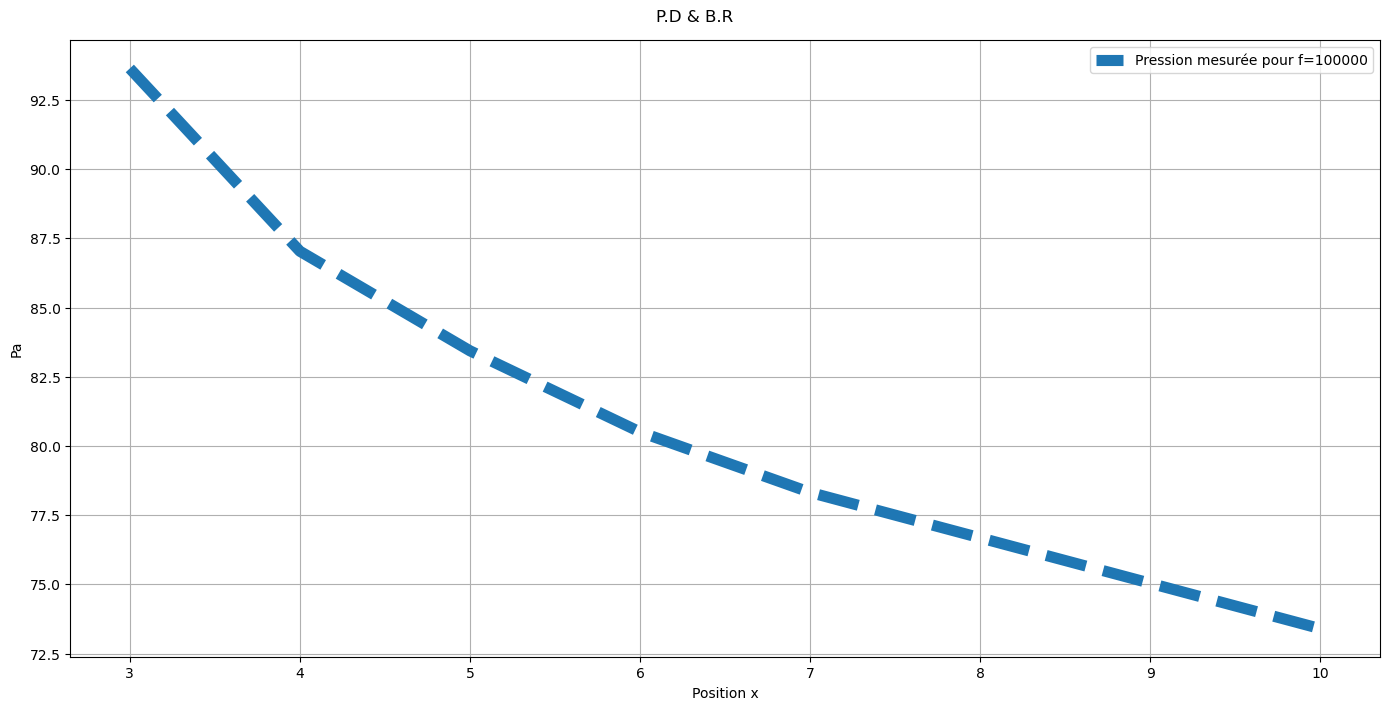

In [35]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 100000 # Frequency in Hz
samples = 1000000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### f = 1MHz

La perte de pression linéique est de -21.08497186040529 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.98648593e-15 1.02188645e-15 6.45447397e-16 4.56689090e-16
 3.71629883e-16 1.75322195e-16]
list pression dB [-200.05889006 -205.83254711 -209.82338284 -212.82818718 -214.61838735
 -221.14386192]


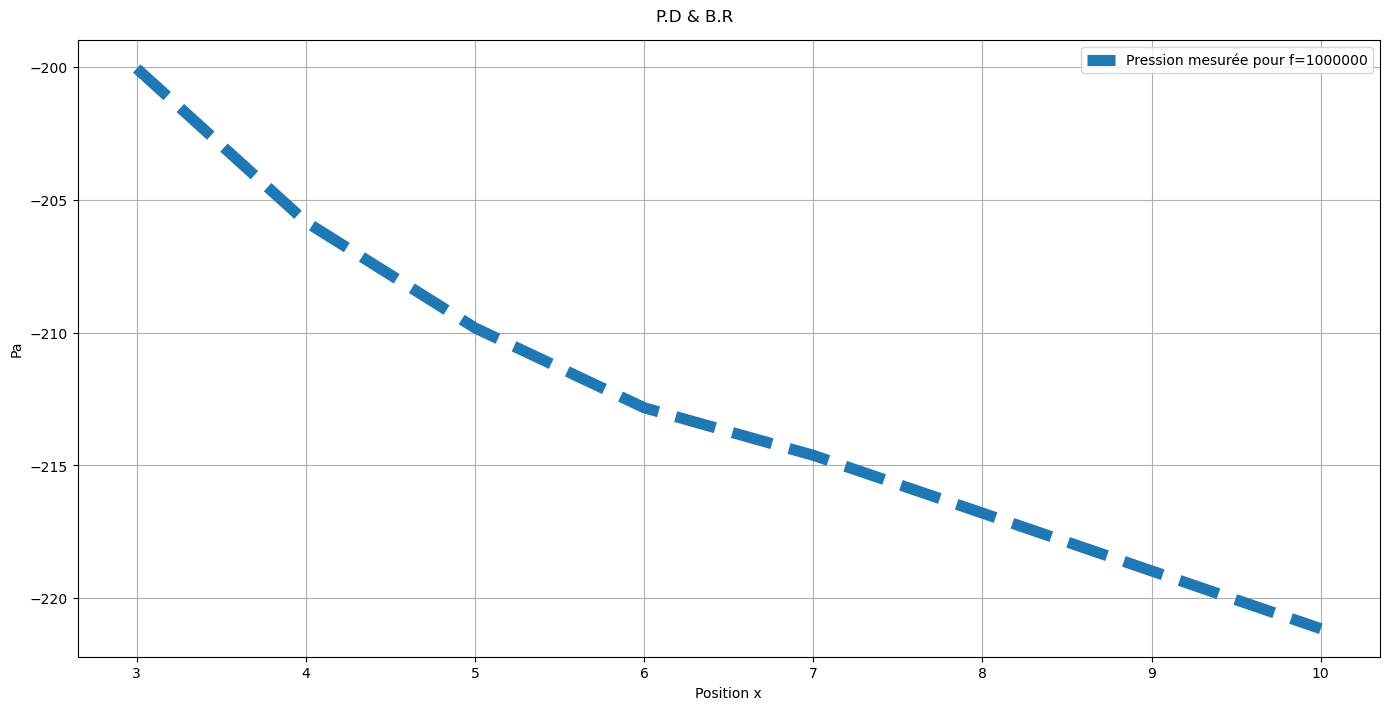

In [36]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 1000000 # Frequency in Hz
samples = 1000000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


## Pression en fonction de la reflexion

### Reflexion = 0

La perte de pression linéique est de -18.089505482118966 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.05994624 0.52831596 0.35022681 0.26254184 0.2109316  0.13207133]
list pression dB [94.48507683 88.43727475 84.86638781 82.36337048 80.46223291 76.39557135]


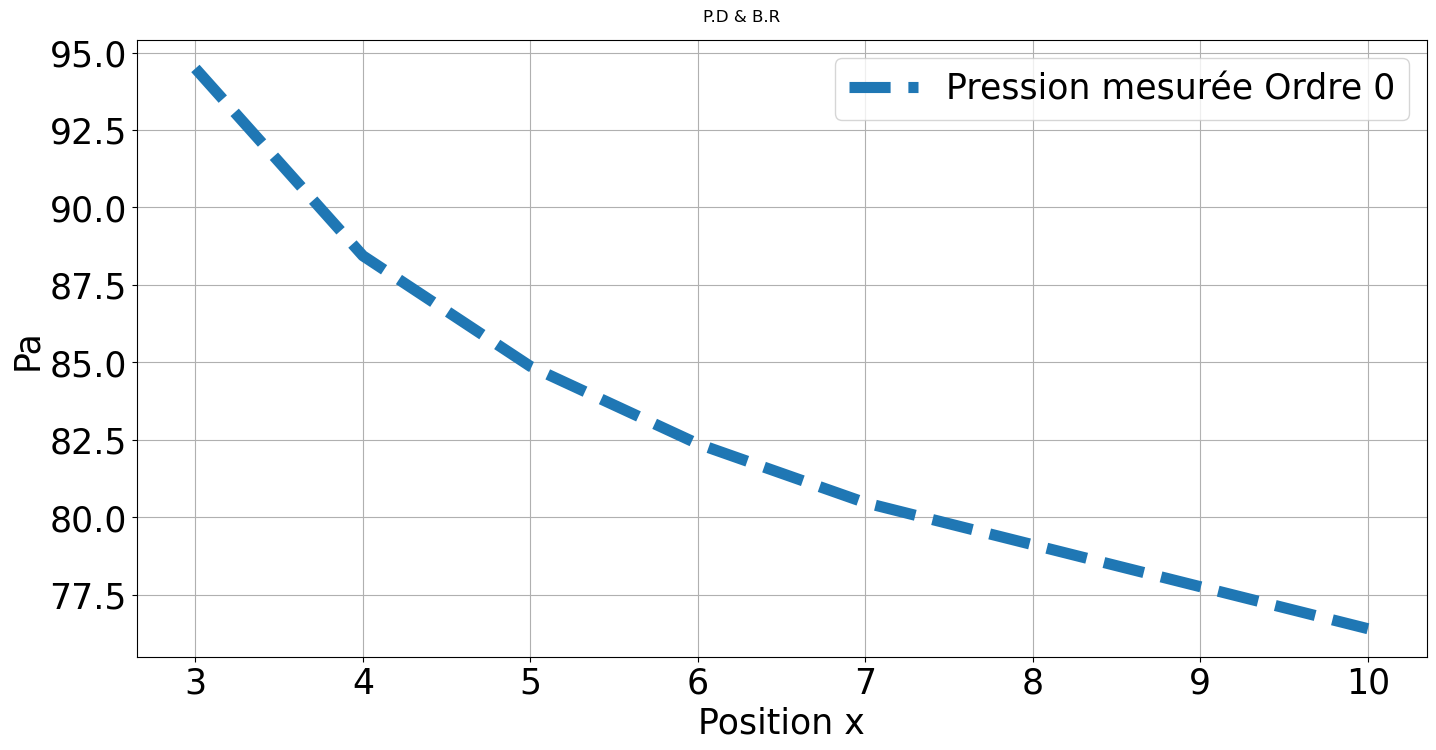

In [37]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 0

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée Ordre {ordre_voulu}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend(fontsize = 25)
plt.ylabel("Pa", fontsize = 25)
plt.tight_layout()
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid()
plt.xlabel("Position x", fontsize = 25)
plt.show()


### Reflexion = 2

La perte de pression linéique est de 5.4957941617965815 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.88646763 2.31395328 1.40268762 1.34397786 1.66996146 1.22903678]
list pression dB [ 99.49238723 101.26649182  96.91861934  96.5472424   98.43352908
  95.77069766]


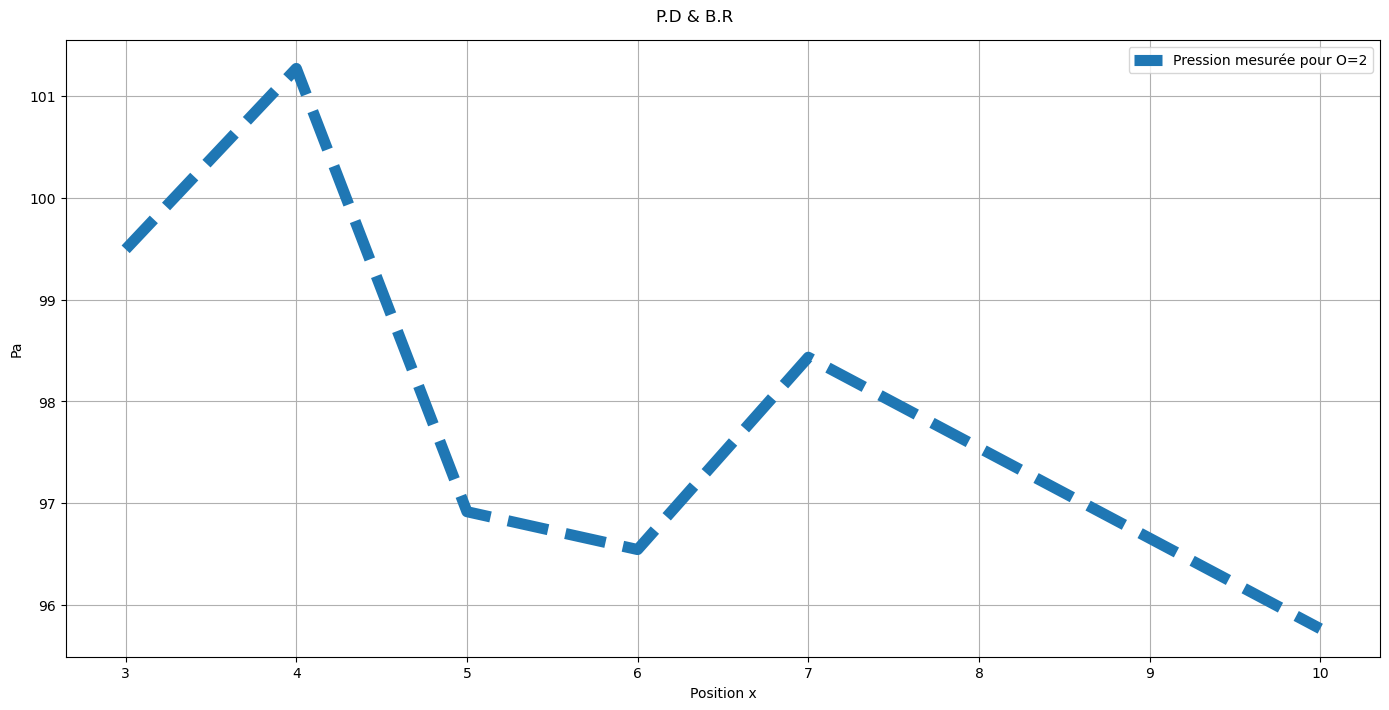

In [38]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 2

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (np.max(pressure_list_dB) -np.min(pressure_list_dB))
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour O={ordre_voulu}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### Reflexion = 3

La perte de pression linéique est de 7.875728045049698 dB 

La perte de pression linéique est de -7.875728045049698 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [1.45230073 1.34176987 1.01787332 0.85129981 0.83525597 0.58650289]
list pression dB [97.22053121 96.53296082 94.13327473 92.58105082 92.4157919  89.34480316]


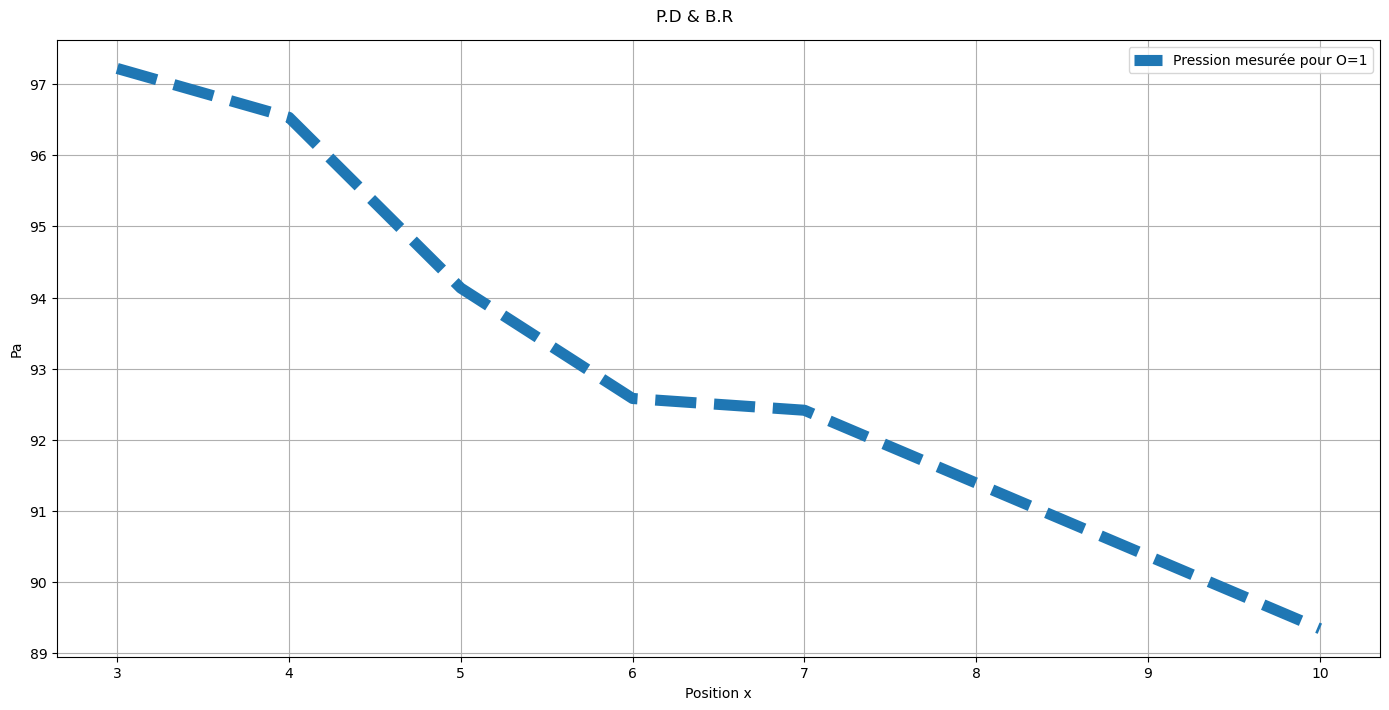

In [39]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 1

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (np.max(pressure_list_dB) -np.min(pressure_list_dB))
print(f"La perte de pression linéique est de {diff} dB \n")

diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour O={ordre_voulu}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### Reflexion = 5

La perte de pression linéique est de -6.2232245998245475 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [4.25563863 3.17584339 3.26716478 3.56162409 3.1688167  2.07875598]
list pression dB [106.55869493 104.01658163 104.26282087 105.01236168 103.99734246
 100.33547033]


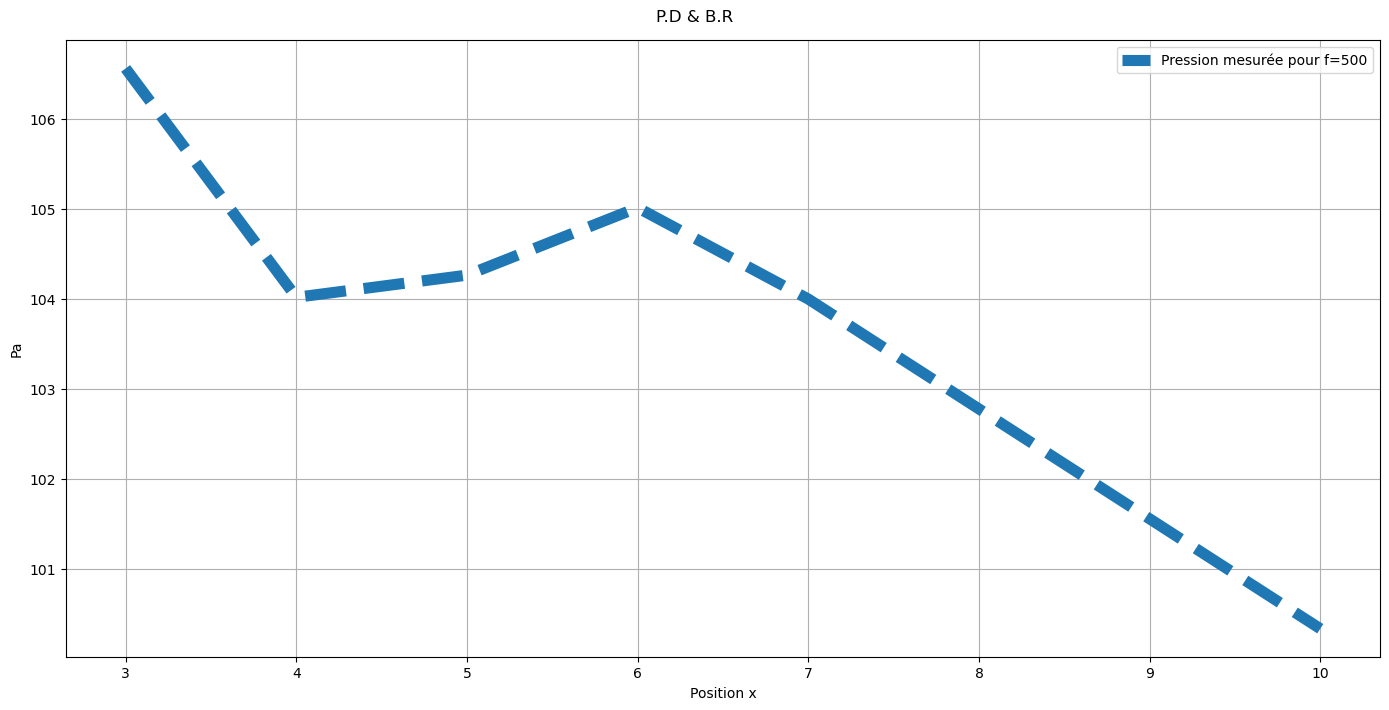

In [40]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 10000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 5

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (pressure_list_dB[-1] - pressure_list_dB[0])
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


### Reflexion = 10

La perte de pression linéique est de 5.9643506891026306 dB 

[ 3.  4.  5.  6.  7. 10.]
list pression [0.8527985  0.66094068 0.77909166 0.59179396 0.42916954 0.57464843]
list pression dB [92.59632861 90.38264968 91.81117125 89.42281059 86.63197792 89.16744464]


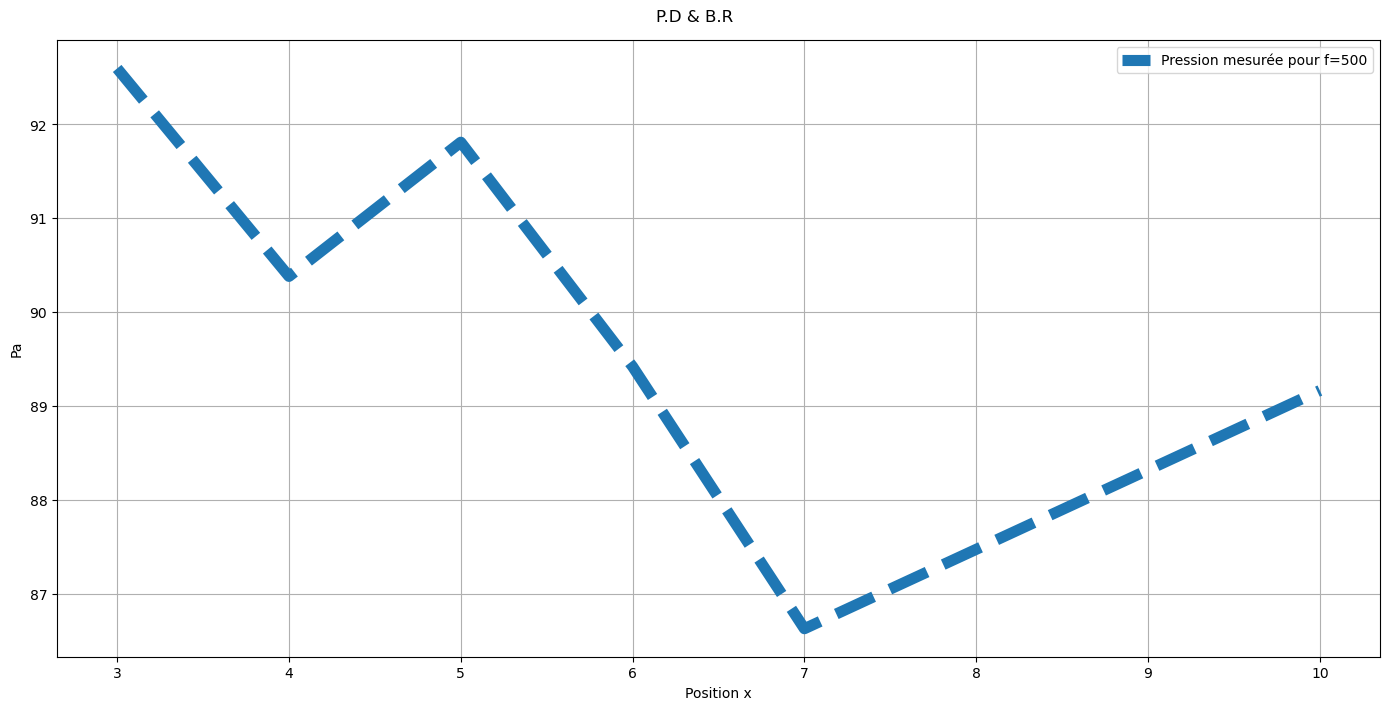

In [41]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 1000000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 10

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))


# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()
#print(room.mic_array.signals.shape)
plt.figure(figsize=[14, 7])
plt.suptitle("P.D & B.R")
pressure_list = []

for mic_index in range(len(room.rir)):
    rir = room.rir[mic_index][0]
    amplitude = np.convolve( extended_signal, rir)
    pressure_list.append(np.max(np.abs(amplitude)))

# Convertion en db
pressure_list = np.array(pressure_list)
pressure_list_dB = 20*np.log10(pressure_list/(20e-6))

# Vérifions que la courbe suit bien une loi en 1/R

pos = R[0]

def decay_model(r, a, b):
    return a / r + b

x = np.linspace(3,10)
popt, pcov = curve_fit(decay_model, pos, pressure_list_dB, bounds=(0, np.inf))
fit_a, fit_b = popt
fit_curve = decay_model(x, fit_a, fit_b)

# Perte de pression linéique : 
diff = (np.max(pressure_list_dB) -np.min(pressure_list_dB))
print(f"La perte de pression linéique est de {diff} dB \n")

print(pos)
print("list pression", pressure_list)
print("list pression dB", pressure_list_dB)
plt.plot(pos,pressure_list_dB, '--', linewidth = 8, label=f"Pression mesurée pour f={f0}")
#plt.plot(x, fit_curve, 'r2', linewidth = 3, label=f"Fit 1/R (a={fit_a:.2f}\nb={fit_b:.2f})")
plt.legend()
plt.ylabel("Pa")
plt.tight_layout()
plt.grid()
plt.xlabel("Position x")
plt.show()


## RIR et suite

### RIR

Moreover, we can plot the RIR for each microphone once the image sources have been computed.

##### Scheme definition with high reflexability

In [42]:
# Generate a sinusoidal signal with a frequency of 500 Hz
f0 = 500 # Frequency in Hz
samples = 48000  # Sampling rate in Hz
duration = 4 / f0  # Duration to capture 4 periods of the signal
t = np.arange(0, duration, 1 / samples)  # Time vector

# Create the sinusoidal signal
signal = np.sin(2 * np.pi * f0 * t)

# Extend the signal with zeros for propagation and reverberation
total_duration = 0.1  # Total signal duration in seconds (adjust as needed)
num_samples = int(total_duration * samples)
extended_signal = np.zeros(num_samples)
extended_signal[:len(signal)] = signal

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
fs = samples
ordre_voulu = 5

# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners, fs=fs, max_order=ordre_voulu, materials=pra.Material(0.2, 0.15), ray_tracing=False, air_absorption=True, absorption=0)
room.extrude(2., materials=pra.Material(0.2, 0.15))

# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# add source and set the signal to WAV file content
room.add_source([2, 0.5, 1.5], signal=extended_signal)

# add two-microphone array
R = np.array([[3,4,5,6,7,10], [0.5,0.5,0.5, 0.5,0.5,0.5], [1.5,1.5,1.5, 1.5,1.5, 1.5]])  # [[x], [y], [z]]
room.add_microphone(R)

# compute image sources
room.image_source_model()

room.compute_rir()

#### Creation bande d'octaves

In [43]:
octav_test = pra.acoustics.octave_bands(fc= 5000, third= False, start= 0, n=8)
octav_test

(array([[  3535.53390593,   7071.06781187],
        [  7071.06781187,  14142.13562373],
        [ 14142.13562373,  28284.27124746],
        [ 28284.27124746,  56568.54249492],
        [ 56568.54249492, 113137.08498985],
        [113137.08498985, 226274.1699797 ],
        [226274.1699797 , 452548.33995939],
        [452548.33995939, 905096.67991878]]),
 array([  5000.,  10000.,  20000.,  40000.,  80000., 160000., 320000.,
        640000.]))

#### Octave bande Factory

In [44]:
octave_factory_test = pra.acoustics.OctaveBandsFactory(base_frequency = 100, fs = 10000, n_fft = 512, keep_dc= False)
print(octave_factory_test.get_bw())
#plt.plot(octave_factory_test.get_bw())

[  70.71067812  141.42135624  282.84271247  565.68542495 1131.3708499
 2262.7416998 ]


#### Analysis

In [45]:
octave_factory_test.analysis(extended_signal)
print(octave_factory_test.all_materialsà)

AttributeError: 'OctaveBandsFactory' object has no attribute 'all_materialsà'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import pyroomacoustics as pra

# Fonction pour créer un filtre passe-bande pour une bande d’octave
def octave_band_filter(rir, fs, fc):
    f_min = fc / np.sqrt(2)
    f_max = fc * np.sqrt(2)
    sos = butter(N=4, Wn=[0.01, 0.99], btype='band', output='sos')
    return sosfilt(sos, rir)

# Simulation d’une pièce avec pyroomacoustics
corners = np.array([[0, 0], [10, 0], [10, 5], [0, 5]]).T
room = pra.Room.from_corners(corners, fs=16000, max_order=5, materials=pra.Material(0.2), air_absorption=True)
room.extrude(3.0)

# Ajout de la source et des microphones
room.add_source([2, 2, 1.5])
R = np.array([[3, 5, 7], [2, 2, 2], [1.5, 1.5, 1.5]])
room.add_microphone(R)

# Calcul des RIR
room.compute_rir()
rir = room.rir[0][0]  # RIR pour le premier micro et la source

# Fréquences centrales des bandes d’octaves
octave_bands = [125, 250, 500, 1000, 2000, 4000, 8000]
fs = room.fs  # Fréquence d’échantillonnage
rir_filtered_bands = []

# Filtrage de la RIR dans chaque bande d’octave
for fc in octave_bands:
    rir_filtered = octave_band_filter(rir, fs, fc)
    rir_filtered_bands.append(rir_filtered)

# Tracé des RIR par bande d’octave
plt.figure(figsize=(10, 6))
for i, fc in enumerate(octave_bands):
    plt.bar(rir_filtered_bands[i], label=f'{fc} Hz')
plt.legend()
plt.xlabel('Échantillons')
plt.ylabel('Amplitude')
plt.title('RIR filtrées en bandes d’octave')
plt.show()


TypeError: bar() missing 1 required positional argument: 'height'

<Figure size 1000x600 with 0 Axes>

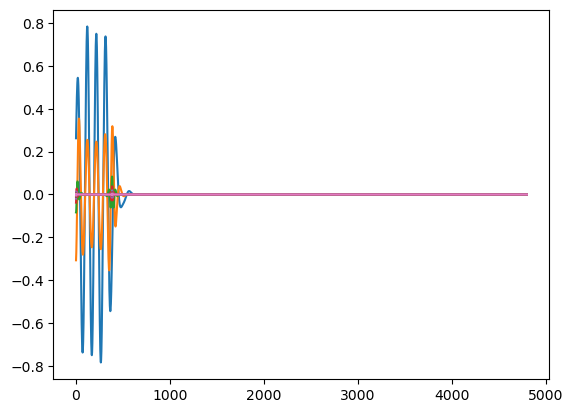

In [ ]:
c = pra.acoustics.OctaveBandsFactory(125)
c.analysis(extended_signal)
plt.plot(c.analysis(extended_signal))

##### Ordre = 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\pierr\AppData\Local\Temp\ipykernel_17956\847357357.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


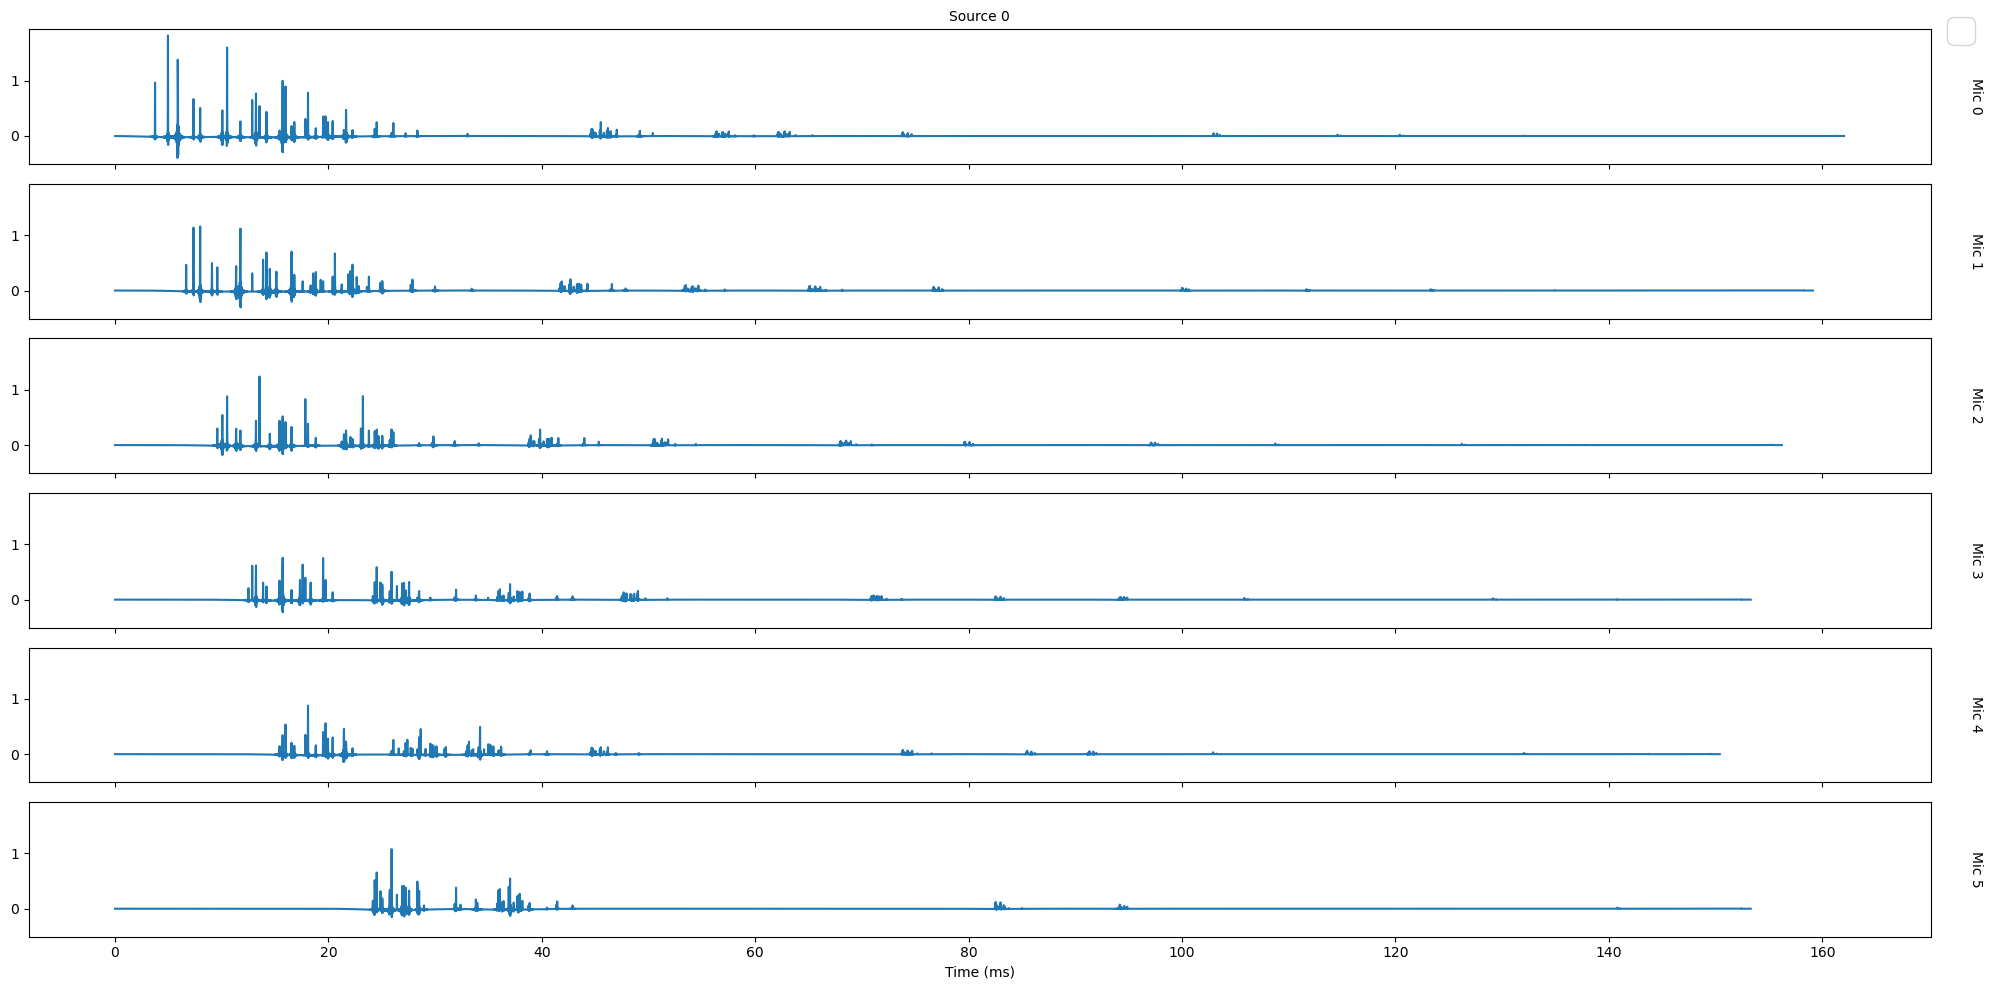

In [ ]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.legend(fontsize = 25)
fig.tight_layout()
fig.show()


##### Ordre = 10

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\pierr\AppData\Local\Temp\ipykernel_17956\847357357.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


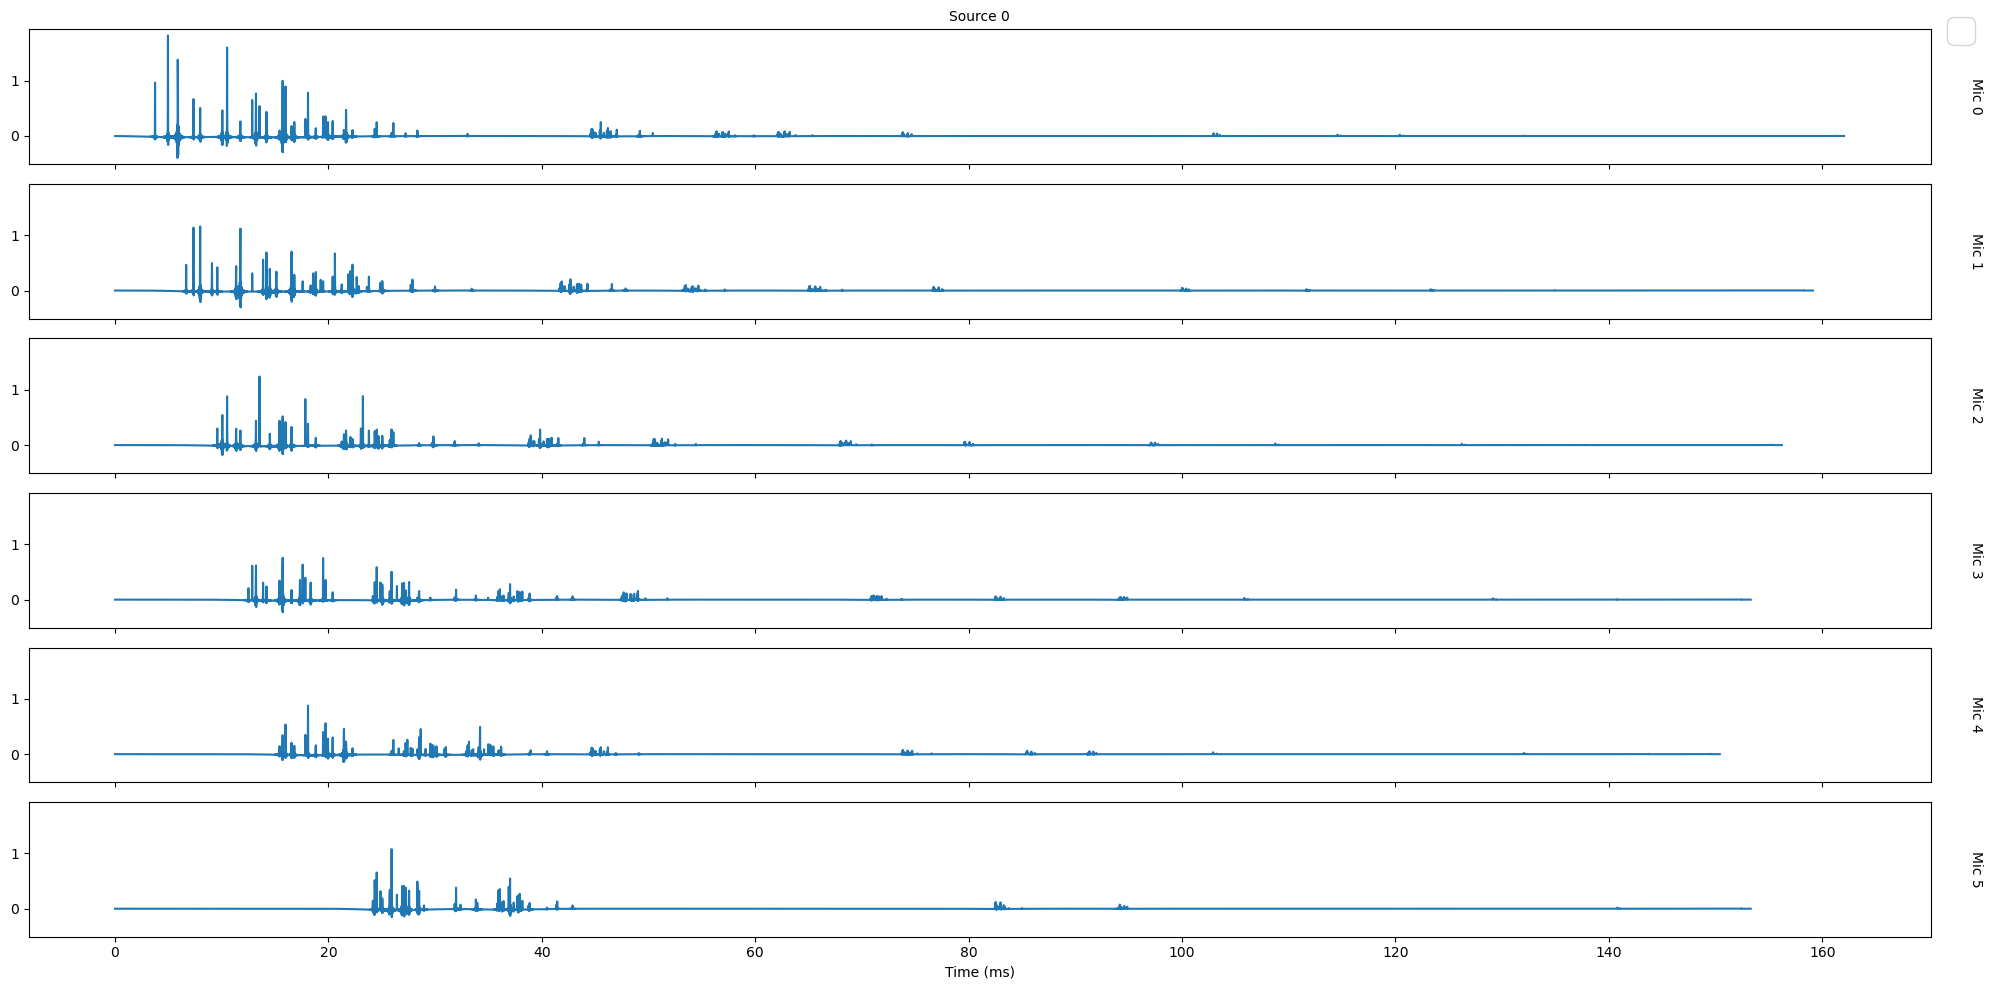

In [ ]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.legend(fontsize = 25)
fig.tight_layout()
fig.show()


##### Signal convolué

In [ ]:
np.convolve(signal,room.rir[0][0])

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

We can now measure the reverberation time of the RIR.

The RT60 is 148 ms


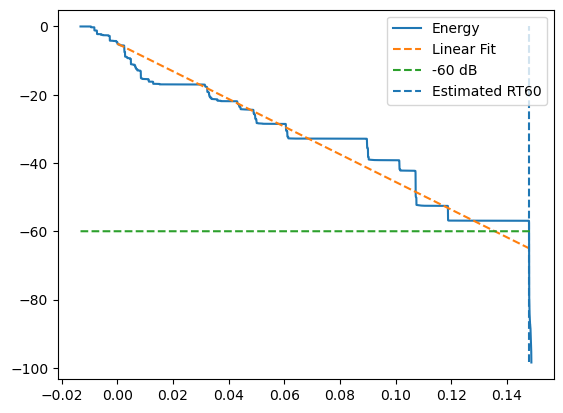

In [ ]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

Moreover, we can simulate our signal convolved with these impulse responses as such:

(6, 1316)


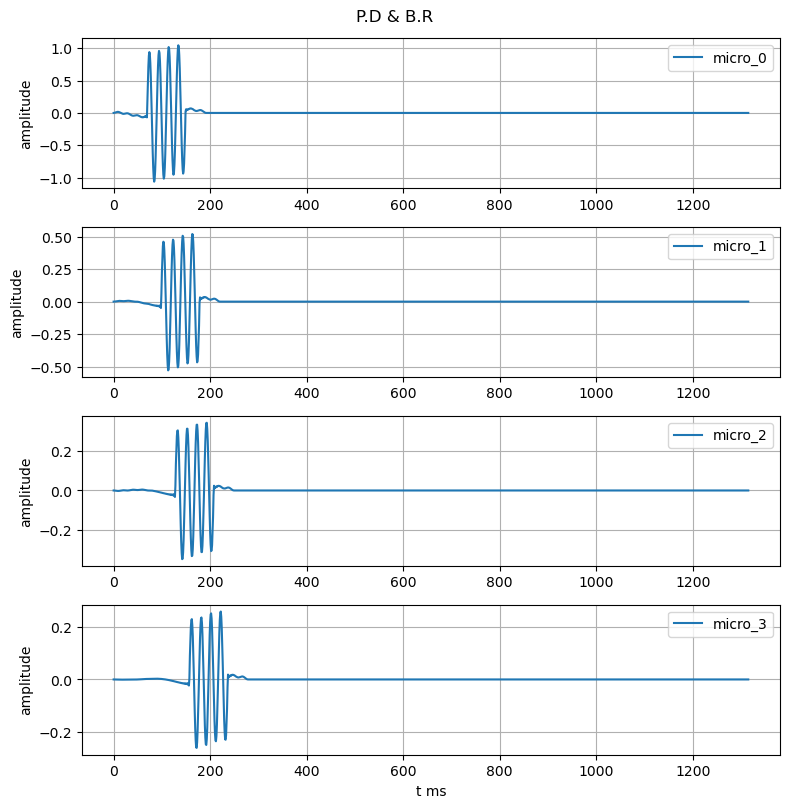

In [ ]:
room.simulate()
print(room.mic_array.signals.shape)
plt.figure(figsize=[8, 8])
plt.suptitle("P.D & B.R")
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(room.mic_array.signals[i],label = f'micro_{i}')
    plt.legend()
    plt.ylabel("amplitude")
    plt.tight_layout()
    plt.grid()

plt.xlabel("t ms")
plt.show()


In [ ]:
# création de la salle

room = pra.ShoeBox(room_dim, fs = 16e3, materials=pra.Material("Wood"))
room.set_air_absorption(coefficients=[
    0.0001,
    0.01,
    0.1,
    1.0
], center_freqs=[
    10,
    100,
    1000,
    10000
])

room.simulate()

